In [6]:

# # Cell 2: Imports
# import os
# import base64
# import io
# import glob
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import random
# from itertools import count
# from PIL import Image
# from collections import deque, namedtuple
# from scipy.stats import norm, t
# from scipy.stats import ttest_ind
# from tqdm import tqdm
# import warnings
# warnings.filterwarnings('ignore')
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torchvision.transforms as T
# import torch.optim as optim
# import gymnasium as gym
# import highway_env
# from gymnasium.wrappers import RecordVideo
# from IPython.display import HTML
# from IPython import display
# plt.style.use('ggplot')
# %matplotlib inline

# # Cell 3: Hyperparameters & Paths
# BUFFER_SIZE = int(5e4)  # Reduced for CPU stability
# BATCH_SIZE = 64
# GAMMA = 0.99
# TAU = 1e-3
# LR = 5e-4
# UPDATE_EVERY = 4
# path_HW5 = r"C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks"
# if not path_HW5.endswith(os.sep):
#     path_HW5 += os.sep
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")
# for subdir in ['Models', 'Data_Average_Reward', 'Videos', 'Images']:
#     os.makedirs(os.path.join(path_HW5, subdir), exist_ok=True)

# # Cell 4: Neural Network Architectures
# class QNetwork_Linear(nn.Module):
#     def __init__(self, state_size, action_size, seed):
#         super(QNetwork_Linear, self).__init__()
#         torch.manual_seed(seed)
#         self.fc1 = nn.Linear(state_size, 125)
#         self.fc2 = nn.Linear(125, 125)
#         self.fc3 = nn.Linear(125, action_size)

#     def forward(self, state):
#         x = F.relu(self.fc1(state))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

# class QNetwork_CNN(nn.Module):
#     def __init__(self, action_size, seed):
#         super(QNetwork_CNN, self).__init__()
#         torch.manual_seed(seed)
#         self.conv1 = nn.Conv2d(3, 128, kernel_size=3)
#         self.conv2 = nn.Conv2d(128, 128, kernel_size=3)
#         self.maxpool = nn.MaxPool2d(kernel_size=2)
#         self.dropout = nn.Dropout(0.1)
#         self.flatten = nn.Flatten()
#         self.fc1 = nn.Linear(38912, 64)
#         self.fc2 = nn.Linear(64, action_size)

#     def forward(self, state):
#         x = self.dropout(self.maxpool(F.relu(self.conv1(state))))
#         x = self.dropout(self.maxpool(F.relu(self.conv2(x))))
#         x = self.flatten(x)
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

# # Cell 5: Replay Buffer
# class ReplayBuffer:
#     def __init__(self, action_size, buffer_size, batch_size, seed):
#         self.action_size = action_size
#         self.memory = deque(maxlen=buffer_size)
#         self.batch_size = batch_size
#         self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
#         random.seed(seed)

#     def add(self, state, action, reward, next_state, done):
#         e = self.experience(state, action, reward, next_state, done)
#         self.memory.append(e)

#     def sample(self):
#         experiences = random.sample(self.memory, k=self.batch_size)
#         states = torch.from_numpy(np.vstack([e.state for e in experiences])).float().to(device)
#         actions = torch.from_numpy(np.vstack([e.action for e in experiences])).long().to(device)
#         rewards = torch.from_numpy(np.vstack([e.reward for e in experiences])).float().to(device)
#         next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences])).float().to(device)
#         dones = torch.from_numpy(np.vstack([e.done for e in experiences]).astype(np.uint8)).float().to(device)
#         return (states, actions, rewards, next_states, dones)

#     def __len__(self):
#         return len(self.memory)

# # Cell 6: Agent
# class Agent:
#     def __init__(self, state_size, action_size, network_type, seed):
#         self.state_size = state_size
#         self.action_size = action_size
#         random.seed(seed)
#         self.network_type = network_type.lower()
#         if self.network_type == 'linear':
#             self.qnetwork_local = QNetwork_Linear(state_size, action_size, seed).to(device)
#             self.qnetwork_target = QNetwork_Linear(state_size, action_size, seed).to(device)
#         else:
#             self.qnetwork_local = QNetwork_CNN(action_size, seed).to(device)
#             self.qnetwork_target = QNetwork_CNN(action_size, seed).to(device)
#         self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)
#         self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
#         self.t_step = 0
#         self.resize = T.Compose([T.ToPILImage(), T.Resize(40, interpolation=Image.Resampling.BICUBIC), T.ToTensor()])

#     def get_screen(self, screen):
#         screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
#         screen = torch.from_numpy(screen).permute(2, 0, 1)
#         return self.resize(screen).unsqueeze(0)

#     def step(self, state, action, reward, next_state, done):
#         self.memory.add(state, action, reward, next_state, done)
#         self.t_step = (self.t_step + 1) % UPDATE_EVERY
#         if self.t_step == 0 and len(self.memory) > BATCH_SIZE:
#             experiences = self.memory.sample()
#             self.learn(experiences, GAMMA)

#     def act(self, state, eps=0):
#         if self.network_type == 'linear':
#             state = torch.from_numpy(state).float().unsqueeze(0).to(device)
#         else:
#             state = state.to(device)
#         self.qnetwork_local.eval()
#         with torch.no_grad():
#             action_values = self.qnetwork_local(state)
#         self.qnetwork_local.train()
#         if random.random() > eps:
#             return np.argmax(action_values.cpu().data.numpy())
#         return random.choice(np.arange(self.action_size))

#     def learn(self, experiences, gamma):
#         states, actions, rewards, next_states, dones = experiences
#         q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
#         q_targets = rewards + gamma * q_targets_next * (1 - dones)
#         q_expected = self.qnetwork_local(states).gather(1, actions)
#         loss = F.mse_loss(q_expected, q_targets)
#         self.optimizer.zero_grad()
#         loss.backward()
#         self.optimizer.step()
#         self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

#     def soft_update(self, local_model, target_model, tau):
#         for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
#             target_param.data.copy_(tau * local_param.data + (1 - tau) * target_param.data)

# # Cell 7: DQN
# class DQN:
#     def __init__(self, env, env_name, model_path, data_path, network_type, env_name_source=None, model_path_source=None, transfer_episode=None):
#         self.env = env.unwrapped
#         self.env_name = env_name
#         self.model_path = model_path
#         self.data_path = data_path
#         self.network_type = network_type.lower()
#         self.env_name_source = env_name_source
#         self.model_path_source = model_path_source
#         self.transfer_episode = transfer_episode
#         self.df_reward = pd.DataFrame()
#         self.seed = [0, 5, 11, 123, 487]
#         self.env.config['policy_frequency'] = self.env.config.get('policy_frequency', 10)

#     def train_with_state(self, n_iteration, n_training_episodes=50, max_step=10000, eps_start=1.0, eps_end=0.001, eps_decay=0.995):
#         print(f"Training agent with state for {self.env_name}...")
#         if n_iteration[0] != 1:
#             prev_file = os.path.join(self.data_path, f'Episodes_reward_run_{n_iteration[0]-1}.xlsx')
#             if os.path.exists(prev_file):
#                 self.df_reward = pd.read_excel(prev_file)

#         for iter in tqdm(n_iteration, desc="Iterations"):
#             episodes_reward = []
#             state_size = int(np.prod(self.env.observation_space.shape))
#             action_size = self.env.action_space.n
#             agent = Agent(state_size, action_size, self.network_type, self.seed[iter-1])
#             if self.env_name_source and self.model_path_source and self.transfer_episode:
#                 local_path = os.path.join(self.model_path_source, f'Models_Run_{iter}', f'checkpoint_dqn_state_{self.env_name_source}_local_{self.transfer_episode}.pth')
#                 target_path = os.path.join(self.model_path_source, f'Models_Run_{iter}', f'checkpoint_dqn_state_{self.env_name_source}_target_{self.transfer_episode}.pth')
#                 if os.path.exists(local_path) and os.path.exists(target_path):
#                     agent.qnetwork_local.load_state_dict(torch.load(local_path, map_location=device))
#                     agent.qnetwork_target.load_state_dict(torch.load(target_path, map_location=device))
#                 else:
#                     print(f"Warning: Transfer models not found at {local_path} or {target_path}")

#             os.makedirs(os.path.join(self.model_path, f'Models_Run_{iter}'), exist_ok=True)
#             eps = eps_start

#             for episode_num in tqdm(range(1, n_training_episodes + 1), desc=f"Iter {iter} Episodes", leave=False):
#                 eps = max(eps_end, eps_decay * eps)
#                 state, _ = self.env.reset()
#                 done = False
#                 total_reward = 0
#                 for _ in range(max_step):
#                     action = agent.act(state.ravel(), eps)
#                     next_state, reward, terminated, truncated, _ = self.env.step(action)
#                     total_reward += reward
#                     agent.step(state.ravel(), action, reward, next_state.ravel(), terminated or truncated)
#                     if terminated or truncated:
#                         break
#                     state = next_state
#                 episodes_reward.append(total_reward)
#                 print(f'\rEpisode {episode_num}\tAvg Reward: {np.mean(episodes_reward):.2f}\tEpsilon: {eps:.3f}', end='')
#                 if episode_num % 10 == 0:
#                     print(f'\rEpisode {episode_num}\tAvg Reward: {np.mean(episodes_reward):.2f}\tEpsilon: {eps:.3f}')
#                     self.df_reward[f'Run_{iter}'] = episodes_reward + [np.nan] * (n_training_episodes - len(episodes_reward))
#                     self.df_reward.to_excel(os.path.join(self.data_path, f'Episodes_reward_run_{iter}_temp.xlsx'), index=False)
#                 if episode_num % 200 == 0:
#                     torch.save(agent.qnetwork_local.state_dict(), os.path.join(self.model_path, f'Models_Run_{iter}', f'checkpoint_dqn_state_{self.env_name}_local_{episode_num}.pth'))
#                     torch.save(agent.qnetwork_target.state_dict(), os.path.join(self.model_path, f'Models_Run_{iter}', f'checkpoint_dqn_state_{self.env_name}_target_{episode_num}.pth'))

#             self.df_reward[f'Run_{iter}'] = episodes_reward
#             self.df_reward.to_excel(os.path.join(self.data_path, f'Episodes_reward_run_{iter}.xlsx'), index=False)
#             temp_file = os.path.join(self.data_path, f'Episodes_reward_run_{iter}_temp.xlsx')
#             if os.path.exists(temp_file):
#                 os.remove(temp_file)
#         return self.df_reward

#     def train_with_observation(self, n_iteration, n_training_episodes=50, max_step=10000, eps_start=1.0, eps_end=0.001, eps_decay=0.995):
#         print(f"Training agent with observation for {self.env_name}...")
#         if n_iteration[0] != 1:
#             prev_file = os.path.join(self.data_path, f'Episodes_reward_run_{n_iteration[0]-1}.xlsx')
#             if os.path.exists(prev_file):
#                 self.df_reward = pd.read_excel(prev_file)

#         for iter in tqdm(n_iteration, desc="Iterations"):
#             episodes_reward = []
#             state_size = int(np.prod(self.env.observation_space.shape))
#             action_size = self.env.action_space.n
#             agent = Agent(state_size, action_size, self.network_type, self.seed[iter-1])
#             if self.env_name_source and self.model_path_source and self.transfer_episode:
#                 local_path = os.path.join(self.model_path_source, f'Models_Run_{iter}', f'checkpoint_dqn_observation_{self.env_name_source}_local_{self.transfer_episode}.pth')
#                 target_path = os.path.join(self.model_path_source, f'Models_Run_{iter}', f'checkpoint_dqn_observation_{self.env_name_source}_target_{self.transfer_episode}.pth')
#                 if os.path.exists(local_path) and os.path.exists(target_path):
#                     agent.qnetwork_local.load_state_dict(torch.load(local_path, map_location=device))
#                     agent.qnetwork_target.load_state_dict(torch.load(target_path, map_location=device))
#                 else:
#                     print(f"Warning: Transfer models not found at {local_path} or {target_path}")

#             os.makedirs(os.path.join(self.model_path, f'Models_Run_{iter}'), exist_ok=True)
#             eps = eps_start

#             for episode_num in tqdm(range(1, n_training_episodes + 1), desc=f"Iter {iter} Episodes", leave=False):
#                 eps = max(eps_end, eps_decay * eps)
#                 self.env.reset()
#                 last_screen = agent.get_screen(self.env.render())
#                 current_screen = agent.get_screen(self.env.render())
#                 state = current_screen - last_screen
#                 done = False
#                 total_reward = 0
#                 for _ in range(max_step):
#                     action = agent.act(state, eps)
#                     _, reward, terminated, truncated, _ = self.env.step(action)
#                     total_reward += reward
#                     last_screen = current_screen
#                     current_screen = agent.get_screen(self.env.render())
#                     next_state = current_screen - last_screen
#                     agent.step(state, action, reward, next_state, terminated or truncated)
#                     if terminated or truncated:
#                         break
#                     state = next_state
#                 episodes_reward.append(total_reward)
#                 print(f'\rEpisode {episode_num}\tAvg Reward: {np.mean(episodes_reward):.2f}\tEpsilon: {eps:.3f}', end='')
#                 if episode_num % 10 == 0:
#                     print(f'\rEpisode {episode_num}\tAvg Reward: {np.mean(episodes_reward):.2f}\tEpsilon: {eps:.3f}')
#                     self.df_reward[f'Run_{iter}'] = episodes_reward + [np.nan] * (n_training_episodes - len(episodes_reward))
#                     self.df_reward.to_excel(os.path.join(self.data_path, f'Episodes_reward_run_{iter}_temp.xlsx'), index=False)
#                 if episode_num % 200 == 0:
#                     torch.save(agent.qnetwork_local.state_dict(), os.path.join(self.model_path, f'Models_Run_{iter}', f'checkpoint_dqn_observation_{self.env_name}_local_{episode_num}.pth'))
#                     torch.save(agent.qnetwork_target.state_dict(), os.path.join(self.model_path, f'Models_Run_{iter}', f'checkpoint_dqn_observation_{self.env_name}_target_{episode_num}.pth'))

#             self.df_reward[f'Run_{iter}'] = episodes_reward
#             self.df_reward.to_excel(os.path.join(self.data_path, f'Episodes_reward_run_{iter}.xlsx'), index=False)
#             temp_file = os.path.join(self.data_path, f'Episodes_reward_run_{iter}_temp.xlsx')
#             if os.path.exists(temp_file):
#                 os.remove(temp_file)
#         return self.df_reward

#     def evaluation(self, video_file, evaluate_type, iter_num, evaluate_episode_num, use_saved_model=True, num_episodes=5):
#         video_dir = os.path.dirname(video_file)
#         os.makedirs(video_dir, exist_ok=True)
#         os.environ["SDL_VIDEODRIVER"] = "windows"
#         state_size = int(np.prod(self.env.observation_space.shape))
#         action_size = self.env.action_space.n
#         agent = Agent(state_size, action_size, self.network_type, seed=11)

#         if use_saved_model:
#             local_path = os.path.join(self.model_path, f'Models_Run_{iter_num}', f'checkpoint_dqn_{evaluate_type}_{self.env_name}_local_{evaluate_episode_num}.pth')
#             target_path = os.path.join(self.model_path, f'Models_Run_{iter_num}', f'checkpoint_dqn_{evaluate_type}_{self.env_name}_target_{evaluate_episode_num}.pth')
#             if os.path.exists(local_path) and os.path.exists(target_path):
#                 agent.qnetwork_local.load_state_dict(torch.load(local_path, map_location=device))
#                 agent.qnetwork_target.load_state_dict(torch.load(target_path, map_location=device))
#             else:
#                 print(f"Error: Models not found at {local_path} or {target_path}. Ensure training completed.")
#                 return None

#         eval_rewards = []
#         for ep in range(num_episodes):
#             env_wrapped = RecordVideo(self.env, video_folder=video_dir, name_prefix=f"{self.env_name}_eval_ep{ep}")
#             frame = env_wrapped.render()
#             if frame is None or np.mean(frame) == 0:
#                 print(f"Warning: Empty frame in episode {ep}. Saving debug frame...")
#                 if frame is not None:
#                     imageio.imwrite(os.path.join(video_dir, f'debug_frame_ep{ep}.png'), frame)
#             if evaluate_type == 'state':
#                 state, _ = env_wrapped.reset()
#                 done = False
#                 ep_reward = 0
#                 while not done:
#                     action = agent.act(state.ravel(), eps=0)
#                     state, reward, terminated, truncated, _ = env_wrapped.step(action)
#                     ep_reward += reward
#                     done = terminated or truncated
#             else:
#                 env_wrapped.reset()
#                 last_screen = agent.get_screen(env_wrapped.render())
#                 current_screen = agent.get_screen(env_wrapped.render())
#                 state = current_screen - last_screen
#                 done = False
#                 ep_reward = 0
#                 while not done:
#                     action = agent.act(state, eps=0)
#                     _, reward, terminated, truncated, _ = env_wrapped.step(action)
#                     ep_reward += reward
#                     last_screen = current_screen
#                     current_screen = agent.get_screen(env_wrapped.render())
#                     state = current_screen - last_screen
#                     done = terminated or truncated
#             env_wrapped.close()
#             eval_rewards.append(ep_reward)
#             print(f"Episode {ep+1}/{num_episodes} Reward: {ep_reward:.2f}")

#         avg_reward = np.mean(eval_rewards)
#         print(f"Average Reward over {num_episodes} episodes: {avg_reward:.2f}")
#         pd.DataFrame({'Episode': list(range(1, num_episodes+1)), 'Reward': eval_rewards}).to_csv(
#             os.path.join(video_dir, f"{self.env_name}_eval_rewards.csv"), index=False)
#         return avg_reward

# # Cell 8: Show and Plot
# class show_and_plot:
#     def __init__(self):
#         pass

#     def show_video(self, directory, file_name):
#         if not directory.endswith(os.sep):
#             directory += os.sep
#         mp4_path = os.path.join(directory, file_name)
#         print(f"Attempting to display video: {mp4_path}")
#         if os.path.exists(mp4_path):
#             try:
#                 with open(mp4_path, 'rb') as f:
#                     video = f.read()
#                 encoded = base64.b64encode(video)
#                 display.display(HTML(f'<video alt="test" autoplay loop controls style="height: 165px; width: 650px;"><source src="data:video/mp4;base64,{encoded.decode()}" type="video/mp4" /></video>'))
#             except Exception as e:
#                 print(f"Error displaying video {mp4_path}: {e}. Try opening the video in a media player.")
#         else:
#             print(f"Video not found: {mp4_path}. Available videos: {glob.glob(os.path.join(directory, '*.mp4'))}")

#     def plot_training_result(self, episodes_rewards, ax, title, label, window=20, stride=5, alpha=0.3):
#         n_iter, n_episode = episodes_rewards.shape
#         smooth_reward = [np.mean(episodes_rewards[:, i*stride:i*stride+window], axis=1) for i in range(int((n_episode - window)/stride) + 1)]
#         smooth_reward = np.array(smooth_reward).T
#         X = range(1, len(smooth_reward[0])*stride + 1, stride)
#         x_bar = np.mean(smooth_reward, axis=0)
#         sigma = np.std(smooth_reward, axis=0)
#         SE = sigma / np.sqrt(n_iter)
#         interval = 1 - alpha
#         if n_iter < 30:
#             t_stat = t.interval(interval, df=n_iter-1)[1]
#             ME = t_stat * SE
#         else:
#             z_stat = norm.interval(interval)[1]
#             ME = z_stat * SE
#         ax.plot(X, x_bar, label=label)
#         if n_iter >= 2:
#             ax.fill_between(X, x_bar - ME, x_bar + ME, alpha=alpha)
#         ax.set_xlabel("Episodes")
#         ax.set_ylabel("Average Reward")
#         ax.set_title(f"{title}\nwindow={window}, stride={stride}")
#         return ax

# # Cell 9: Part 1 - Environment Setup and Visualization
# print("Visualizing highway-v0 environment...")
# env = gym.make('highway-v0', render_mode='rgb_array')
# env.unwrapped.config.update({
#     "observation": {
#         "type": "Kinematics",
#         "vehicles_count": 5,
#         "features": ["presence", "x", "y", "vx", "vy"],
#         "absolute": False
#     },
#     "policy_frequency": 10,
#     "screen_width": 600,
#     "screen_height": 150,
#     "centering_position": [0.5, 0.5],
#     "scaling": 1.0
# })
# try:
#     obs, _ = env.reset()
#     frame = env.render()
#     print("Highway-v0 Frame shape:", frame.shape if frame is not None else "None")
#     print("Frame sample (top-left):", frame[0, 0, :] if frame is not None else "None")
#     print("Frame mean:", np.mean(frame) if frame is not None else "None")
#     if frame is not None and not np.all(frame == 0):
#         imageio.imwrite(os.path.join(path_HW5, 'Videos', 'debug_frame_highway-v0.png'), frame)
#         plt.imshow(frame)
#         plt.title("Highway-v0 Sample Frame")
#         plt.show()
#     else:
#         print("Warning: Black or empty frame for highway-v0")
# except Exception as e:
#     print(f"Error during highway-v0 rendering: {str(e)}")
# finally:
#     env.close()

# # Cell 10: Part 2 - Merge-v0
# video_path = os.path.join(path_HW5, 'Videos')
# model_path = os.path.join(path_HW5, 'Models/1_Models_merge')
# data_path_1 = os.path.join(path_HW5, 'Data_Average_Reward/1_Data_merge')
# env_name = 'merge-v0'
# env = gym.make(env_name, render_mode='rgb_array')
# env.unwrapped.config.update({
#     "observation": {
#         "type": "Kinematics",
#         "vehicles_count": 5,
#         "features": ["presence", "x", "y", "vx", "vy"],
#         "absolute": False
#     },
#     "policy_frequency": 10,
#     "screen_width": 600,
#     "screen_height": 150,
#     "centering_position": [0.5, 0.5],
#     "scaling": 1.0
# })
# dqn_merge = DQN(env, env_name, model_path, data_path_1, 'linear')

# # Training
# print("Starting training for Cell 10 (Merge-v0)...")
# df_reward_merge = dqn_merge.train_with_state(n_iteration=[1,2,3,4,5], n_training_episodes=50)

# # Evaluation
# print("Starting evaluation for Cell 10...")
# avg_reward = dqn_merge.evaluation(os.path.join(video_path, "merge.mp4"), 'state', iter_num=5, evaluate_episode_num=200)
# show_and_plot().show_video(video_path, "merge-v0_eval_ep0-episode-0.mp4")

# # Plotting
# print("Generating plot for Cell 10...")
# df_merge = pd.read_excel(os.path.join(data_path_1, 'Episodes_reward_run_5.xlsx'))
# ep_merge = df_merge.T.to_numpy()
# fig, ax = plt.subplots(figsize=(12, 7.5))
# ax = show_and_plot().plot_training_result(ep_merge, ax, 'DQN Merge', 'Merge task with state', window=10, stride=2)
# plt.legend()
# plt.show()
# fig.savefig(os.path.join(path_HW5, 'Images/1-Merge-task-state.png'), dpi=300)

# # Cell 11: Part 3 - Highway-Fast-v0
# video_path = os.path.join(path_HW5, 'Videos')
# model_path = os.path.join(path_HW5, 'Models/2_Models_fastHighway')
# data_path_2 = os.path.join(path_HW5, 'Data_Average_Reward/2_Data_fastHighway')
# env_name = 'highway-fast-v0'
# env = gym.make(env_name, render_mode='rgb_array')
# env.unwrapped.config.update({
#     "observation": {
#         "type": "Kinematics",
#         "vehicles_count": 5,
#         "features": ["presence", "x", "y", "vx", "vy"],
#         "absolute": False
#     },
#     "policy_frequency": 5,
#     "screen_width": 600,
#     "screen_height": 150,
#     "centering_position": [0.5, 0.5],
#     "scaling": 1.0
# })
# dqn_fastHighway = DQN(env, env_name, model_path, data_path_2, 'linear')

# # Training
# print("Starting training for Cell 11...")
# df_reward_fast = dqn_fastHighway.train_with_state(n_iteration=[1,2,3,4,5], n_training_episodes=50)

# # Evaluation
# print("Starting evaluation for Cell 11...")
# avg_reward = dqn_fastHighway.evaluation(os.path.join(video_path, "fastHighway.mp4"), 'state', iter_num=5, evaluate_episode_num=200)
# show_and_plot().show_video(video_path, "highway-fast-v0_eval_ep0-episode-0.mp4")

# # Cell 12: Part 3 - Transfer Learning
# model_path_source = os.path.join(path_HW5, 'Models/1_Models_merge')
# model_path_dest = os.path.join(path_HW5, 'Models/3_Models_merge_transfer_learning_to_fastHighway')
# data_path_3 = os.path.join(path_HW5, 'Data_Average_Reward/3_Data_merge_transfer_learning_to_fastHighway')
# env_name_source = 'merge-v0'
# env = gym.make('highway-fast-v0', render_mode='rgb_array')
# env.unwrapped.config.update({
#     "observation": {
#         "type": "Kinematics",
#         "vehicles_count": 5,
#         "features": ["presence", "x", "y", "vx", "vy"],
#         "absolute": False
#     },
#     "policy_frequency": 5,
#     "screen_width": 600,
#     "screen_height": 150,
#     "centering_position": [0.5, 0.5],
#     "scaling": 1.0
# })

# # Check if source models exist
# print("Checking for source models for Cell 12...")
# for iter in range(1, 6):
#     local_path = os.path.join(model_path_source, f'Models_Run_{iter}', f'checkpoint_dqn_state_{env_name_source}_local_200.pth')
#     target_path = os.path.join(model_path_source, f'Models_Run_{iter}', f'checkpoint_dqn_state_{env_name_source}_target_200.pth')
#     if not os.path.exists(local_path) or not os.path.exists(target_path):
#         print(f"Error: Source model {local_path} or {target_path} not found. Run Cell 10 first.")
#         raise FileNotFoundError(f"Missing {local_path} or {target_path}")

# dqn_transfer = DQN(env, 'highway-fast-v0', model_path_dest, data_path_3, 'linear', env_name_source, model_path_source, transfer_episode=200)

# # Training
# print("Starting training for Cell 12...")
# df_reward_transfer = dqn_transfer.train_with_state(n_iteration=[1,2,3,4,5], n_training_episodes=50)

# # Evaluation
# print("Starting evaluation for Cell 12...")
# avg_reward = dqn_transfer.evaluation(os.path.join(video_path, "fastHighway_transferred_from_merge.mp4"), 'state', iter_num=5, evaluate_episode_num=200)
# show_and_plot().show_video(video_path, "highway-fast-v0_eval_ep0-episode-0.mp4")

# # Plot Comparison
# print("Generating comparison plot for Cell 12...")
# df_fast = pd.read_excel(os.path.join(data_path_2, 'Episodes_reward_run_5.xlsx'))
# df_trans = pd.read_excel(os.path.join(data_path_3, 'Episodes_reward_run_5.xlsx'))
# ep_fast = df_fast.T.to_numpy()
# ep_trans = df_trans.T.to_numpy()
# fig, ax = plt.subplots(figsize=(12, 7.5))
# ax = show_and_plot().plot_training_result(ep_fast, ax, 'DQN Fast', 'Fast Highway', window=10, stride=2)
# ax = show_and_plot().plot_training_result(ep_trans, ax, 'DQN Transfer', 'Transfer from Merge', window=10, stride=2)
# plt.legend()
# plt.show()
# fig.savefig(os.path.join(path_HW5, 'Images/2-fastHighway_with_and_without_transfer_learning_training_on-state.png'), dpi=300)

In [7]:
# %pip install --upgrade pip
# %pip install gymnasium==0.29.1 highway-env torch torchvision moviepy openpyxl tqdm pandas numpy matplotlib scipy pillow imageio opencv-python pygame

# Cell 2: Imports


In [21]:
# Import libraries for reinforcement learning, plotting, and video handling
import os
import base64
import io
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from itertools import count
from PIL import Image
from collections import deque, namedtuple
from scipy.stats import norm, t
from scipy.stats import ttest_ind
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
import gymnasium as gym
import highway_env
from gymnasium.wrappers import RecordVideo
from IPython.display import HTML
from IPython import display
import imageio  # Added for saving images
plt.style.use('ggplot')
%matplotlib inline

# Cell 3: Hyperparameters & Paths

In [22]:
# Define hyperparameters and project paths
BUFFER_SIZE = int(1e5)  # Replay buffer size
BATCH_SIZE = 64         # Minibatch size
GAMMA = 0.99            # Discount factor
TAU = 1e-3              # Soft update parameter
LR = 5e-4               # Learning rate
UPDATE_EVERY = 4        # Network update frequency

# Project root path (update if different)
path_HW5 = r"C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks"

# Ensure trailing slash
if not path_HW5.endswith("\\"):
    path_HW5 += "\\"

# Set device (CPU or GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device.type}")

# Create directories for outputs
for subdir in ['Models', 'Data_Average_Reward', 'Videos', 'Images']:
    os.makedirs(os.path.join(path_HW5, subdir), exist_ok=True)

Using device: cpu


# Cell 4: Neural Network Architectures

In [23]:
# Define neural network architectures for DQN
class QNetwork_Linear(nn.Module):
    def __init__(self, state_size, action_size, seed):
        super(QNetwork_Linear, self).__init__()
        torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 125)
        self.fc2 = nn.Linear(125, 125)
        self.fc3 = nn.Linear(125, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class QNetwork_CNN(nn.Module):
    def __init__(self, action_size, seed):
        super(QNetwork_CNN, self).__init__()
        torch.manual_seed(seed)
        self.conv1 = nn.Conv2d(3, 128, kernel_size=3)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.dropout = nn.Dropout(0.1)
        self.conv2 = nn.Conv2d(128, 128, kernel_size=3)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(38912, 64)
        self.fc2 = nn.Linear(64, action_size)

    def forward(self, state):
        x = self.dropout(self.maxpool(self.relu(self.conv1(state))))
        x = self.dropout(self.maxpool(self.relu(self.conv2(x))))
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Cell 5: Replay Buffer

In [24]:
# Define replay buffer for storing experiences
class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences]).astype(np.uint8)).float().to(device)
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

# Cell 6: Agent

In [25]:
# Define DQN agent
class Agent:
    def __init__(self, state_size, action_size, network_type, seed):
        self.state_size = state_size
        self.action_size = action_size
        random.seed(seed)
        self.network_type = network_type.lower()
        if self.network_type == 'linear':
            self.qnetwork_local = QNetwork_Linear(state_size, action_size, seed).to(device)
            self.qnetwork_target = QNetwork_Linear(state_size, action_size, seed).to(device)
        else:
            self.qnetwork_local = QNetwork_CNN(action_size, seed).to(device)
            self.qnetwork_target = QNetwork_CNN(action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.t_step = 0
        self.resize = T.Compose([T.ToPILImage(), T.Resize(40, interpolation=Image.Resampling.BICUBIC), T.ToTensor()])

    def get_screen(self, screen):
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen).permute(2, 0, 1)
        return self.resize(screen).unsqueeze(0)

    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0 and len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def act(self, state, eps=0):
        if self.network_type == 'linear':
            state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        else:
            state = state.to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences
        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        q_targets = rewards + gamma * q_targets_next * (1 - dones)
        q_expected = self.qnetwork_local(states).gather(1, actions)
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1 - tau) * target_param.data)

# Cell 7: DQN

In [13]:
# Define DQN training and evaluation
class DQN:
    def __init__(self, env, env_name, model_path, data_path, network_type, env_name_source=None, model_path_source=None, transfer_episode=None):
        self.env = env.unwrapped
        self.env_name = env_name
        self.model_path = model_path
        self.data_path = data_path
        self.network_type = network_type.lower()
        self.env_name_source = env_name_source
        self.model_path_source = model_path_source
        self.transfer_episode = transfer_episode
        self.df_reward = pd.DataFrame()
        self.seed = [0, 5, 11, 123, 487]
        self.env.config['policy_frequency'] = self.env.config.get('policy_frequency', 10)

    def train_with_state(self, n_iteration, n_training_episodes, max_step, eps_start=1.0, eps_end=0.001, eps_decay=0.995):
        print(f"Training agent with state for {self.env_name}...")
        if n_iteration[0] != 1:
            prev_file = os.path.join(self.data_path, f'Episodes_reward_run_{n_iteration[0]-1}.xlsx')
            if os.path.exists(prev_file):
                self.df_reward = pd.read_excel(prev_file)

        for iter in tqdm(n_iteration, desc="Iterations"):
            episodes_reward = []
            state_size = int(np.prod(self.env.observation_space.shape))
            action_size = self.env.action_space.n
            agent = Agent(state_size, action_size, self.network_type, self.seed[iter-1])
            if self.env_name_source and self.model_path_source and self.transfer_episode:
                local_path = os.path.join(self.model_path_source, f'Models_Run_{iter}', f'checkpoint_dqn_state_{self.env_name_source}_local_{self.transfer_episode}.pth')
                target_path = os.path.join(self.model_path_source, f'Models_Run_{iter}', f'checkpoint_dqn_state_{self.env_name_source}_target_{self.transfer_episode}.pth')
                if os.path.exists(local_path) and os.path.exists(target_path):
                    agent.qnetwork_local.load_state_dict(torch.load(local_path, map_location=device))
                    agent.qnetwork_target.load_state_dict(torch.load(target_path, map_location=device))
                else:
                    print(f"Warning: Transfer models not found at {local_path} or {target_path}")

            os.makedirs(os.path.join(self.model_path, f'Models_Run_{iter}'), exist_ok=True)
            eps = eps_start

            for episode_num in tqdm(range(1, n_training_episodes + 1), desc=f"Iter {iter} Episodes", leave=False):
                eps = max(eps_end, eps_decay * eps)
                state, _ = self.env.reset()
                done = False
                total_reward = 0
                for _ in range(max_step):
                    action = agent.act(state.ravel(), eps)
                    next_state, reward, terminated, truncated, _ = self.env.step(action)
                    total_reward += reward
                    agent.step(state.ravel(), action, reward, next_state.ravel(), terminated or truncated)
                    if terminated or truncated:
                        break
                    state = next_state
                episodes_reward.append(total_reward)
                print(f'\rEpisode {episode_num}\tAvg Reward: {np.mean(episodes_reward):.2f}\tEpsilon: {eps:.3f}', end='')
                if episode_num % 10 == 0:
                    print(f'\rEpisode {episode_num}\tAvg Reward: {np.mean(episodes_reward):.2f}\tEpsilon: {eps:.3f}')
                    self.df_reward[f'Run_{iter}'] = episodes_reward + [np.nan] * (n_training_episodes - len(episodes_reward))
                    self.df_reward.to_excel(os.path.join(self.data_path, f'Episodes_reward_run_{iter}_temp.xlsx'), index=False)
                if episode_num % 200 == 0:
                    torch.save(agent.qnetwork_local.state_dict(), os.path.join(self.model_path, f'Models_Run_{iter}', f'checkpoint_dqn_state_{self.env_name}_local_{episode_num}.pth'))
                    torch.save(agent.qnetwork_target.state_dict(), os.path.join(self.model_path, f'Models_Run_{iter}', f'checkpoint_dqn_state_{self.env_name}_target_{episode_num}.pth'))

            self.df_reward[f'Run_{iter}'] = episodes_reward
            self.df_reward.to_excel(os.path.join(self.data_path, f'Episodes_reward_run_{iter}.xlsx'), index=False)
            temp_file = os.path.join(self.data_path, f'Episodes_reward_run_{iter}_temp.xlsx')
            if os.path.exists(temp_file):
                os.remove(temp_file)
        return self.df_reward

    def train_with_observation(self, n_iteration, n_training_episodes, max_step, eps_start=1.0, eps_end=0.001, eps_decay=0.995):
        print(f"Training agent with observation for {self.env_name}...")
        if n_iteration[0] != 1:
            prev_file = os.path.join(self.data_path, f'Episodes_reward_run_{n_iteration[0]-1}.xlsx')
            if os.path.exists(prev_file):
                self.df_reward = pd.read_excel(prev_file)

        for iter in tqdm(n_iteration, desc="Iterations"):
            episodes_reward = []
            state_size = int(np.prod(self.env.observation_space.shape))
            action_size = self.env.action_space.n
            agent = Agent(state_size, action_size, self.network_type, self.seed[iter-1])
            if self.env_name_source and self.model_path_source and self.transfer_episode:
                local_path = os.path.join(self.model_path_source, f'Models_Run_{iter}', f'checkpoint_dqn_observation_{self.env_name_source}_local_{self.transfer_episode}.pth')
                target_path = os.path.join(self.model_path_source, f'Models_Run_{iter}', f'checkpoint_dqn_observation_{self.env_name_source}_target_{self.transfer_episode}.pth')
                if os.path.exists(local_path) and os.path.exists(target_path):
                    agent.qnetwork_local.load_state_dict(torch.load(local_path, map_location=device))
                    agent.qnetwork_target.load_state_dict(torch.load(target_path, map_location=device))
                else:
                    print(f"Warning: Transfer models not found at {local_path} or {target_path}")

            os.makedirs(os.path.join(self.model_path, f'Models_Run_{iter}'), exist_ok=True)
            eps = eps_start

            for episode_num in tqdm(range(1, n_training_episodes + 1), desc=f"Iter {iter} Episodes", leave=False):
                eps = max(eps_end, eps_decay * eps)
                self.env.reset()
                last_screen = agent.get_screen(self.env.render())
                current_screen = agent.get_screen(self.env.render())
                state = current_screen - last_screen
                done = False
                total_reward = 0
                for _ in range(max_step):
                    action = agent.act(state, eps)
                    _, reward, terminated, truncated, _ = self.env.step(action)
                    total_reward += reward
                    last_screen = current_screen
                    current_screen = agent.get_screen(self.env.render())
                    next_state = current_screen - last_screen
                    agent.step(state, action, reward, next_state, terminated or truncated)
                    if terminated or truncated:
                        break
                    state = next_state
                episodes_reward.append(total_reward)
                print(f'\rEpisode {episode_num}\tAvg Reward: {np.mean(episodes_reward):.2f}\tEpsilon: {eps:.3f}', end='')
                if episode_num % 10 == 0:
                    print(f'\rEpisode {episode_num}\tAvg Reward: {np.mean(episodes_reward):.2f}\tEpsilon: {eps:.3f}')
                    self.df_reward[f'Run_{iter}'] = episodes_reward + [np.nan] * (n_training_episodes - len(episodes_reward))
                    self.df_reward.to_excel(os.path.join(self.data_path, f'Episodes_reward_run_{iter}_temp.xlsx'), index=False)
                if episode_num % 200 == 0:
                    torch.save(agent.qnetwork_local.state_dict(), os.path.join(self.model_path, f'Models_Run_{iter}', f'checkpoint_dqn_observation_{self.env_name}_local_{episode_num}.pth'))
                    torch.save(agent.qnetwork_target.state_dict(), os.path.join(self.model_path, f'Models_Run_{iter}', f'checkpoint_dqn_observation_{self.env_name}_target_{episode_num}.pth'))

            self.df_reward[f'Run_{iter}'] = episodes_reward
            self.df_reward.to_excel(os.path.join(self.data_path, f'Episodes_reward_run_{iter}.xlsx'), index=False)
            temp_file = os.path.join(self.data_path, f'Episodes_reward_run_{iter}_temp.xlsx')
            if os.path.exists(temp_file):
                os.remove(temp_file)
        return self.df_reward

    def evaluation(self, video_file, evaluate_type, iter_num, evaluate_episode_num, use_saved_model=True, num_episodes=5):
        video_dir = os.path.dirname(video_file)
        os.makedirs(video_dir, exist_ok=True)
        os.environ["SDL_VIDEODRIVER"] = "windows"
        state_size = int(np.prod(self.env.observation_space.shape))
        action_size = self.env.action_space.n
        agent = Agent(state_size, action_size, self.network_type, seed=11)
        crashes = 0

        if use_saved_model:
            local_path = os.path.join(self.model_path, f'Models_Run_{iter_num}', f'checkpoint_dqn_{evaluate_type}_{self.env_name}_local_{evaluate_episode_num}.pth')
            target_path = os.path.join(self.model_path, f'Models_Run_{iter_num}', f'checkpoint_dqn_{evaluate_type}_{self.env_name}_target_{evaluate_episode_num}.pth')
            if os.path.exists(local_path) and os.path.exists(target_path):
                agent.qnetwork_local.load_state_dict(torch.load(local_path, map_location=device))
                agent.qnetwork_target.load_state_dict(torch.load(target_path, map_location=device))
            else:
                print(f"Error: Models not found at {local_path} or {target_path}")
                return None, 0

        eval_rewards = []
        for ep in range(num_episodes):
            env_wrapped = RecordVideo(self.env, video_folder=video_dir, name_prefix=f"{self.env_name}_eval_ep{ep}")
            frame = env_wrapped.render()
            if frame is None or np.mean(frame) == 0:
                print(f"Warning: Empty frame in episode {ep}. Saving debug frame...")
                if frame is not None:
                    imageio.imwrite(os.path.join(video_dir, f'debug_frame_ep{ep}.png'), frame)
            if evaluate_type == 'state':
                state, _ = env_wrapped.reset()
                done = False
                ep_reward = 0
                while not done:
                    action = agent.act(state.ravel(), eps=0)
                    state, reward, terminated, truncated, info = env_wrapped.step(action)
                    ep_reward += reward
                    if 'crashed' in info and info['crashed']:
                        crashes += 1
                    done = terminated or truncated
            else:
                env_wrapped.reset()
                last_screen = agent.get_screen(env_wrapped.render())
                current_screen = agent.get_screen(env_wrapped.render())
                state = current_screen - last_screen
                done = False
                ep_reward = 0
                while not done:
                    action = agent.act(state, eps=0)
                    _, reward, terminated, truncated, info = env_wrapped.step(action)
                    ep_reward += reward
                    if 'crashed' in info and info['crashed']:
                        crashes += 1
                    last_screen = current_screen
                    current_screen = agent.get_screen(env_wrapped.render())
                    state = current_screen - last_screen
                    done = terminated or truncated
            env_wrapped.close()
            eval_rewards.append(ep_reward)
            print(f"Episode {ep+1}/{num_episodes} Reward: {ep_reward:.2f}")

        avg_reward = np.mean(eval_rewards)
        crash_rate = crashes / num_episodes
        print(f"Average Reward over {num_episodes} episodes: {avg_reward:.2f}")
        print(f"Crash Rate: {crash_rate:.2%}")
        pd.DataFrame({'Episode': list(range(1, num_episodes+1)), 'Reward': eval_rewards}).to_csv(
            os.path.join(video_dir, f"{self.env_name}_eval_rewards.csv"), index=False)
        return avg_reward, crash_rate

# Cell 8: Show and Plot

In [14]:
# Define visualization utilities
class show_and_plot:
    def __init__(self):
        pass

    def show_video(self, directory, file_name):
        if not directory.endswith(os.sep):
            directory += os.sep
        mp4_path = os.path.join(directory, file_name)
        print(f"Attempting to display video: {mp4_path}")
        if os.path.exists(mp4_path):
            try:
                with open(mp4_path, 'rb') as f:
                    video = f.read()
                encoded = base64.b64encode(video)
                display.display(HTML(f'<video alt="test" autoplay loop controls style="height: 165px; width: 650px;"><source src="data:video/mp4;base64,{encoded.decode()}" type="video/mp4" /></video>'))
            except Exception as e:
                print(f"Error displaying video {mp4_path}: {e}. Try opening in a media player.")
        else:
            print(f"Video not found: {mp4_path}. Available videos: {glob.glob(os.path.join(directory, '*.mp4'))}")

    def plot_training_result(self, episodes_rewards, ax, title, label, window=20, stride=5, alpha=0.3):
        n_iter, n_episode = episodes_rewards.shape
        smooth_reward = [np.mean(episodes_rewards[:, i*stride:i*stride+window], axis=1) for i in range(int((n_episode - window)/stride) + 1)]
        smooth_reward = np.array(smooth_reward).T
        X = range(1, len(smooth_reward[0])*stride + 1, stride)
        x_bar = np.mean(smooth_reward, axis=0)
        sigma = np.std(smooth_reward, axis=0)
        SE = sigma / np.sqrt(n_iter)
        interval = 1 - alpha
        if n_iter < 30:
            t_stat = t.interval(interval, df=n_iter-1)[1]
            ME = t_stat * SE
        else:
            z_stat = norm.interval(interval)[1]
            ME = z_stat * SE
        ax.plot(X, x_bar, label=label)
        if n_iter >= 2:
            ax.fill_between(X, x_bar - ME, x_bar + ME, alpha=alpha)
        ax.set_xlabel("Episodes")
        ax.set_ylabel("Average Reward")
        ax.set_title(f"{title}\nwindow={window}, stride={stride}")
        return ax

# Cell 9: Part 1 - Environment Setup and Visualization

In [15]:
# Visualize highway-v0 environment
print("Visualizing highway-v0 environment...")
env = gym.make('highway-v0', render_mode='rgb_array')
env.unwrapped.config.update({
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 5,
        "features": ["presence", "x", "y", "vx", "vy"],
        "absolute": False
    },
    "policy_frequency": 10,
    "screen_width": 600,
    "screen_height": 150,
    "centering_position": [0.5, 0.5],
    "scaling": 1.0
})
try:
    obs, _ = env.reset()
    frame = env.render()
    print("Highway-v0 Frame shape:", frame.shape if frame is not None else "None")
    print("Frame sample (top-left):", frame[0, 0, :] if frame is not None else "None")
    print("Frame mean:", np.mean(frame) if frame is not None else "None")
    if frame is not None and not np.all(frame == 0):
        imageio.imwrite(os.path.join(path_HW5, 'Videos', 'debug_frame_highway-v0.png'), frame)
        plt.imshow(frame)
        plt.title("Highway-v0 Sample Frame")
        plt.show()
    else:
        print("Warning: Black or empty frame for highway-v0")
except Exception as e:
    print(f"Error during highway-v0 rendering: {str(e)}")
finally:
    env.close()

Visualizing highway-v0 environment...
Highway-v0 Frame shape: (150, 600, 3)
Frame sample (top-left): [100 100 100]
Frame mean: 103.74288888888888
Error during highway-v0 rendering: name 'imageio' is not defined


# Cell 10: Part 2 - Merge-v0

Starting training for Cell 10 (Merge-v0)...
Training agent with state for merge-v0...


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
Episode 1	Avg Reward: 188.42	Epsilon: 0.995crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 2	Avg Reward: 183.26	Epsilon: 0.990crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
Episode 3	Avg Reward: 177.03	Epsilon: 0.985crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 4	Avg Reward: 156.96	Epsilon: 0.980crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 5	Avg Reward: 153.10	Epsilon: 0.975crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 7	Avg Reward: 135.40	Epsilon: 0.966crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashTrue
overFalse
Episode 8	Avg Reward: 140.04	Epsilon: 0.961crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 11	Avg Reward: 129.28	Epsilon: 0.946crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 12	Avg Reward: 127.69	Epsilon: 0.942crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 13	Avg Reward: 125.10	Epsilon: 0.937crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 14	Avg Reward: 123.36	Epsilon: 0.932crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 15	Avg Reward: 124.90	Epsilon: 0.928

Iter 1 Episodes:  30%|███       | 15/50 [00:24<01:34,  2.69s/it]

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 16	Avg Reward: 123.97	Epsilon: 0.923crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashTrue
overFalse
Episode 17	Avg Reward: 122.49	Epsilon: 0.918crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 18	Avg Reward: 120.42	Epsilon: 0.914crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 19	Avg Reward: 117.92	Epsilon: 0.909crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashTrue
overFalse
Episode 20	Avg Reward: 117.54	Epsilon: 0.905
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse


crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 21	Avg Reward: 116.72	Epsilon: 0.900crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 22	Avg Reward: 118.41	Epsilon: 0.896crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 23	Avg Reward: 115.99	Epsilon: 0.891crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 24	Avg Reward: 116.62	Epsilon: 0.887crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 25	Avg Reward: 115.34	Epsilon: 0.882crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

Episode 26	Avg Reward: 117.36	Epsilon: 0.878crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse


crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 27	Avg Reward: 115.76	Epsilon: 0.873crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 29	Avg Reward: 114.00	Epsilon: 0.865crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 30	Avg Reward: 114.75	Epsilon: 0.860
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse


crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 31	Avg Reward: 114.38	Epsilon: 0.856crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 32	Avg Reward: 113.78	Epsilon: 0.852crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 33	Avg Reward: 112.36	Epsilon: 0.848crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 34	Avg Reward: 110.86	Epsilon: 0.843crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 35	Avg Reward: 110.15	Epsilon: 0.839crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 36	Avg Reward: 109.97	Epsilon: 0.835crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 37	Avg Reward: 109.34	Epsilon: 0.831crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 38	Avg Reward: 108.06	Epsilon: 0.827

Iter 1 Episodes:  76%|███████▌  | 38/50 [00:41<00:07,  1.67it/s]

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashTrue
overFalse
Episode 39	Avg Reward: 107.20	Epsilon: 0.822crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 40	Avg Reward: 106.16	Epsilon: 0.818
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse


crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 41	Avg Reward: 105.27	Epsilon: 0.814crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 42	Avg Reward: 105.65	Epsilon: 0.810crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 43	Avg Reward: 105.99	Epsilon: 0.806crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashTrue
overFalse
Episode 44	Avg Reward: 105.76	Epsilon: 0.802crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 45	Avg Reward: 105.18	Epsilon: 0.798crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 46	Avg Reward: 105.51	Epsilon: 0.794crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 47	Avg Reward: 104.83	Epsilon: 0.790crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 48	Avg Reward: 104.68	Epsilon: 0.786crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 49	Avg Reward: 104.44	Epsilon: 0.782crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

Iterations:  20%|██        | 1/5 [00:50<03:23, 50.76s/it]

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 50	Avg Reward: 105.13	Epsilon: 0.778


crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 1	Avg Reward: 68.19	Epsilon: 0.995crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 2	Avg Reward: 77.66	Epsilon: 0.990crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 3	Avg Reward: 72.00	Epsilon: 0.985crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 4	Avg Reward: 70.47	Epsilon: 0.980crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 5	Avg Reward: 85.09	Epsilon: 0.975

Iter 2 Episodes:  10%|█         | 5/50 [00:03<00:32,  1.38it/s]

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashTrue
overFalse
Episode 6	Avg Reward: 84.21	Epsilon: 0.970crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 7	Avg Reward: 82.25	Epsilon: 0.966crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashTrue
overFalse
Episode 8	Avg Reward: 84.87	Epsilon: 0.961crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashTrue
overFalse
Episode 9	Avg Reward: 83.12	Epsilon: 0.956crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 11	Avg Reward: 91.46	Epsilon: 0.946crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 12	Avg Reward: 89.22	Epsilon: 0.942crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 13	Avg Reward: 87.52	Epsilon: 0.937crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 14	Avg Reward: 86.50	Epsilon: 0.932crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 15	Avg Reward: 88.60	Epsilon: 0.928

Iter 2 Episodes:  30%|███       | 15/50 [00:18<00:35,  1.02s/it]

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 16	Avg Reward: 88.28	Epsilon: 0.923crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 18	Avg Reward: 92.16	Epsilon: 0.914crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 19	Avg Reward: 91.54	Epsilon: 0.909crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 20	Avg Reward: 92.91	Epsilon: 0.905
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 21	Avg Reward: 91.49	Epsilon: 0.900crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashTrue
overFalse
Episode 22	Avg Reward: 91.23	Epsilon: 0.896crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 23	Avg Reward: 91.06	Epsilon: 0.891crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashTrue
overFalse
Episode 24	Avg Reward: 92.34	Epsilon: 0.887crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 25	Avg Reward: 92.42	Epsilon: 0.882crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashTrue
overFalse
Episode 26	Avg Reward: 93.00	Epsilon: 0.878crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 27	Avg Reward: 94.33	Epsilon: 0.873crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 28	Avg Reward: 94.46	Epsilon: 0.869crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 29	Avg Reward: 93.68	Epsilon: 0.865crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 30	Avg Reward: 93.08	Epsilon: 0.860
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 31	Avg Reward: 95.09	Epsilon: 0.856crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 32	Avg Reward: 94.14	Epsilon: 0.852crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 33	Avg Reward: 94.02	Epsilon: 0.848crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 34	Avg Reward: 93.75	Epsilon: 0.843crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 35	Avg Reward: 94.41	Epsilon: 0.839crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 36	Avg Reward: 94.49	Epsilon: 0.835crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 38	Avg Reward: 97.75	Epsilon: 0.827crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 39	Avg Reward: 97.63	Epsilon: 0.822crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 40	Avg Reward: 96.95	Epsilon: 0.818
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 41	Avg Reward: 97.85	Epsilon: 0.814crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 42	Avg Reward: 97.03	Epsilon: 0.810crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 43	Avg Reward: 97.95	Epsilon: 0.806crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 44	Avg Reward: 97.74	Epsilon: 0.802crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 45	Avg Reward: 98.03	Epsilon: 0.798crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 46	Avg Reward: 97.53	Epsilon: 0.794crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 47	Avg Reward: 97.92	Epsilon: 0.790crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 48	Avg Reward: 98.56	Epsilon: 0.786crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 49	Avg Reward: 98.78	Epsilon: 0.782crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

Iterations:  40%|████      | 2/5 [01:50<02:47, 55.98s/it]

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overTrue
Episode 50	Avg Reward: 100.19	Epsilon: 0.778


crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 1	Avg Reward: 154.42	Epsilon: 0.995crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 2	Avg Reward: 132.32	Epsilon: 0.990crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 3	Avg Reward: 125.93	Epsilon: 0.985crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 4	Avg Reward: 134.39	Epsilon: 0.980crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 5	Avg Reward: 130.72	Epsilon: 0.975crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 6	Avg Reward: 121.98	Epsilon: 0.970crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 7	Avg Reward: 113.25	Epsilon: 0.966crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 8	Avg Reward: 111.74	Epsilon: 0.961crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 9	Avg Reward: 111.34	Epsilon: 0.956crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
Episode 10	Avg Reward: 119.29	Epsilon: 0.951
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse


crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 11	Avg Reward: 118.10	Epsilon: 0.946crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 12	Avg Reward: 113.73	Epsilon: 0.942crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 13	Avg Reward: 112.60	Epsilon: 0.937crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 14	Avg Reward: 110.81	Epsilon: 0.932crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 15	Avg Reward: 111.91	Epsilon: 0.928crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 16	Avg Reward: 109.04	Epsilon: 0.923crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 17	Avg Reward: 108.71	Epsilon: 0.918crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 18	Avg Reward: 107.59	Epsilon: 0.914crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 19	Avg Reward: 105.61	Epsilon: 0.909crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 20	Avg Reward: 105.40	Epsilon: 0.905
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse


crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 21	Avg Reward: 104.47	Epsilon: 0.900crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 22	Avg Reward: 104.95	Epsilon: 0.896crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 23	Avg Reward: 104.04	Epsilon: 0.891crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 24	Avg Reward: 104.35	Epsilon: 0.887crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 25	Avg Reward: 103.04	Epsilon: 0.882crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 26	Avg Reward: 103.76	Epsilon: 0.878crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 27	Avg Reward: 104.05	Epsilon: 0.873crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 28	Avg Reward: 102.97	Epsilon: 0.869crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 29	Avg Reward: 104.31	Epsilon: 0.865crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 30	Avg Reward: 104.11	Epsilon: 0.860
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse


crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 31	Avg Reward: 104.55	Epsilon: 0.856crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 32	Avg Reward: 103.30	Epsilon: 0.852crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 33	Avg Reward: 103.73	Epsilon: 0.848crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 34	Avg Reward: 102.57	Epsilon: 0.843crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashTrue
overFalse
Episode 35	Avg Reward: 103.39	Epsilon: 0.839crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 36	Avg Reward: 104.07	Epsilon: 0.835crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 37	Avg Reward: 103.27	Epsilon: 0.831crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 38	Avg Reward: 102.84	Epsilon: 0.827crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 39	Avg Reward: 102.30	Epsilon: 0.822crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 40	Avg Reward: 102.82	Epsilon: 0.818
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse


crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 41	Avg Reward: 102.80	Epsilon: 0.814crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 42	Avg Reward: 102.26	Epsilon: 0.810crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 43	Avg Reward: 102.33	Epsilon: 0.806crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 44	Avg Reward: 101.96	Epsilon: 0.802crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 45	Avg Reward: 101.05	Epsilon: 0.798crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 46	Avg Reward: 100.82	Epsilon: 0.794crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 47	Avg Reward: 100.42	Epsilon: 0.790crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 48	Avg Reward: 99.71	Epsilon: 0.786crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
Episode 49	Avg Reward: 101.63	Epsilon: 0.782crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

Iterations:  60%|██████    | 3/5 [02:29<01:36, 48.17s/it]

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 50	Avg Reward: 100.76	Epsilon: 0.778


crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashTrue
overFalse
Episode 2	Avg Reward: 83.42	Epsilon: 0.990crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 3	Avg Reward: 89.62	Epsilon: 0.985crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 4	Avg Reward: 84.03	Epsilon: 0.980crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 5	Avg Reward: 90.80	Epsilon: 0.975crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 6	Avg Reward: 85.33	Epsilon: 0.970crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 7	Avg Reward: 85.47	Epsilon: 0.966

Iter 4 Episodes:  14%|█▍        | 7/50 [00:04<00:25,  1.69it/s]

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 8	Avg Reward: 84.89	Epsilon: 0.961crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 11	Avg Reward: 82.69	Epsilon: 0.946crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 12	Avg Reward: 85.13	Epsilon: 0.942crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 13	Avg Reward: 84.36	Epsilon: 0.937crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 14	Avg Reward: 85.31	Epsilon: 0.932crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashTrue
overFalse
Episode 15	Avg Reward: 87.98	Epsilon: 0.928crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashTrue
overFalse
Episode 16	Avg Reward: 86.54	Epsilon: 0.923crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 17	Avg Reward: 85.87	Epsilon: 0.918crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashTrue
overFalse
Episode 18	Avg Reward: 85.94	Epsilon: 0.914crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashTrue
overFalse
Episode 19	Avg Reward: 85.56	Epsilon: 0.909crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 20	Avg Reward: 85.68	Epsilon: 0.905
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 21	Avg Reward: 87.82	Epsilon: 0.900crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 22	Avg Reward: 90.02	Epsilon: 0.896crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 23	Avg Reward: 92.86	Epsilon: 0.891crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 24	Avg Reward: 92.87	Epsilon: 0.887crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 25	Avg Reward: 93.15	Epsilon: 0.882crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 26	Avg Reward: 91.82	Epsilon: 0.878crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 27	Avg Reward: 91.75	Epsilon: 0.873crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 28	Avg Reward: 92.09	Epsilon: 0.869crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 29	Avg Reward: 93.59	Epsilon: 0.865crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 30	Avg Reward: 93.71	Epsilon: 0.860
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 31	Avg Reward: 94.30	Epsilon: 0.856crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 32	Avg Reward: 93.52	Epsilon: 0.852crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 33	Avg Reward: 92.89	Epsilon: 0.848crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
Episode 34	Avg Reward: 95.40	Epsilon: 0.843crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 35	Avg Reward: 96.07	Epsilon: 0.839crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashTrue
overFalse
Episode 36	Avg Reward: 96.33	Epsilon: 0.835crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 37	Avg Reward: 95.71	Epsilon: 0.831crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 38	Avg Reward: 95.26	Epsilon: 0.827crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 39	Avg Reward: 95.45	Epsilon: 0.822

Iter 4 Episodes:  78%|███████▊  | 39/50 [00:35<00:06,  1.66it/s]

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashTrue
overFalse
Episode 41	Avg Reward: 95.07	Epsilon: 0.814crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 42	Avg Reward: 95.91	Epsilon: 0.810crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 43	Avg Reward: 95.17	Epsilon: 0.806crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashTrue
overFalse
Episode 44	Avg Reward: 94.94	Epsilon: 0.802crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 45	Avg Reward: 95.41	Epsilon: 0.798crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 46	Avg Reward: 95.70	Epsilon: 0.794crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashTrue
overFalse
Episode 47	Avg Reward: 96.65	Epsilon: 0.790crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 48	Avg Reward: 96.23	Epsilon: 0.786crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

Episode 49	Avg Reward: 95.97	Epsilon: 0.782crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

Iterations:  80%|████████  | 4/5 [03:12<00:46, 46.19s/it]

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 50	Avg Reward: 95.95	Epsilon: 0.778


crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 1	Avg Reward: 70.81	Epsilon: 0.995crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 2	Avg Reward: 81.38	Epsilon: 0.990crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashTrue
overFalse
Episode 3	Avg Reward: 80.81	Epsilon: 0.985crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 4	Avg Reward: 83.30	Epsilon: 0.980crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 5	Avg Reward: 87.88	Epsilon: 0.975crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 6	Avg Reward: 89.93	Epsilon: 0.970crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 7	Avg Reward: 85.98	Epsilon: 0.966crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overTrue
Episode 8	Avg Reward: 98.78	Epsilon: 0.961crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 9	Avg Reward: 98.41	Epsilon: 0.956crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 11	Avg Reward: 100.03	Epsilon: 0.946crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 12	Avg Reward: 104.37	Epsilon: 0.942crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 13	Avg Reward: 101.01	Epsilon: 0.937crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
Episode 14	Avg Reward: 107.35	Epsilon: 0.932crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 15	Avg Reward: 108.76	Epsilon: 0.928crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 16	Avg Reward: 110.42	Epsilon: 0.923crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 17	Avg Reward: 109.84	Epsilon: 0.918crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 18	Avg Reward: 109.89	Epsilon: 0.914crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 19	Avg Reward: 109.14	Epsilon: 0.909crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 20	Avg Reward: 111.08	Epsilon: 0.905
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse


crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 21	Avg Reward: 110.19	Epsilon: 0.900crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 22	Avg Reward: 107.88	Epsilon: 0.896crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 23	Avg Reward: 108.05	Epsilon: 0.891crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashTrue
overFalse
Episode 24	Avg Reward: 106.37	Epsilon: 0.887crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 25	Avg Reward: 106.53	Epsilon: 0.882crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 26	Avg Reward: 107.21	Epsilon: 0.878crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 27	Avg Reward: 107.87	Epsilon: 0.873crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 28	Avg Reward: 107.39	Epsilon: 0.869crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 29	Avg Reward: 107.22	Epsilon: 0.865crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 30	Avg Reward: 108.12	Epsilon: 0.860
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse


crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 31	Avg Reward: 109.31	Epsilon: 0.856crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashTrue
overFalse
Episode 32	Avg Reward: 110.56	Epsilon: 0.852crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 33	Avg Reward: 109.39	Epsilon: 0.848crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 34	Avg Reward: 109.59	Epsilon: 0.843crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 35	Avg Reward: 109.75	Epsilon: 0.839crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashTrue
overFalse
Episode 36	Avg Reward: 109.17	Epsilon: 0.835crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 37	Avg Reward: 110.09	Epsilon: 0.831crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 38	Avg Reward: 110.02	Epsilon: 0.827crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overTrue
Episode 39	Avg Reward: 111.56	Epsilon: 0.822crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 40	Avg Reward: 111.55	Epsilon: 0.818
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse


crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 41	Avg Reward: 110.80	Epsilon: 0.814crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 42	Avg Reward: 110.40	Epsilon: 0.810crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 43	Avg Reward: 109.84	Epsilon: 0.806crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 44	Avg Reward: 110.76	Epsilon: 0.802crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 45	Avg Reward: 110.55	Epsilon: 0.798crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 46	Avg Reward: 109.65	Epsilon: 0.794crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 47	Avg Reward: 108.67	Epsilon: 0.790crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 48	Avg Reward: 107.88	Epsilon: 0.786crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 49	Avg Reward: 106.86	Epsilon: 0.782crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

Iterations: 100%|██████████| 5/5 [03:51<00:00, 46.30s/it]


Starting evaluation for Cell 10...
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse

MoviePy - Done !
MoviePy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\merge-v0_eval_ep0-episode-0.mp4
Episode 1/5 Reward: 76.14
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse

MoviePy - Done !
MoviePy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\merge-v0_eval_ep1-episode-0.mp4
Episode 2/5 Reward: 174.75
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFals

MoviePy - Done !
MoviePy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\merge-v0_eval_ep2-episode-0.mp4


Episode 3/5 Reward: 66.44
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFal

MoviePy - Done !
MoviePy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\merge-v0_eval_ep3-episode-0.mp4


Episode 4/5 Reward: 127.41
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFa

MoviePy - Done !
MoviePy - video ready C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\merge-v0_eval_ep4-episode-0.mp4
Episode 5/5 Reward: 56.44
Average Reward over 5 episodes: 100.24
Crash Rate: 80.00%
Attempting to display video: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\merge-v0_eval_ep0-episode-0.mp4


Generating plot for Cell 10...


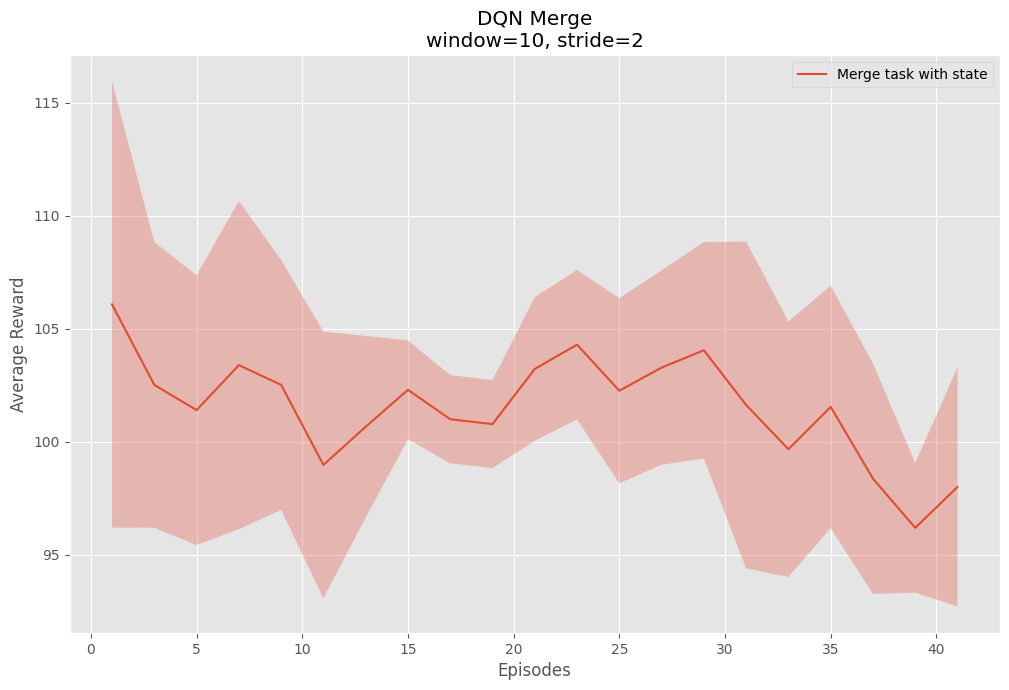

In [17]:
# Train and evaluate DQN on merge-v0
video_path = os.path.join(path_HW5, 'Videos')
model_path = os.path.join(path_HW5, 'Models/1_Models_merge')
data_path_1 = os.path.join(path_HW5, 'Data_Average_Reward/1_Data_merge')
env_name = 'merge-v0'
env = gym.make(env_name, render_mode='rgb_array')
env.unwrapped.config.update({
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 5,
        "features": ["presence", "x", "y", "vx", "vy"],
        "absolute": False
    },
    "policy_frequency": 10,
    "screen_width": 600,
    "screen_height": 150,
    "centering_position": [0.5, 0.5],
    "scaling": 1.0
})
dqn_merge = DQN(env, env_name, model_path, data_path_1, 'linear')

# Training
print("Starting training for Cell 10 (Merge-v0)...")
df_reward_merge = dqn_merge.train_with_state(n_iteration=[1,2,3,4,5], n_training_episodes=50, max_step=10000)

# Evaluation
print("Starting evaluation for Cell 10...")
avg_reward, crash_rate = dqn_merge.evaluation(os.path.join(video_path, "merge.mp4"), 'state', iter_num=5, evaluate_episode_num=200)
show_and_plot().show_video(video_path, "merge-v0_eval_ep0-episode-0.mp4")

# Plotting
print("Generating plot for Cell 10...")
df_merge = pd.read_excel(os.path.join(data_path_1, 'Episodes_reward_run_5.xlsx'))
ep_merge = df_merge.T.to_numpy()
fig, ax = plt.subplots(figsize=(12, 7.5))
ax = show_and_plot().plot_training_result(ep_merge, ax, 'DQN Merge', 'Merge task with state', window=10, stride=2)
plt.legend()
plt.show()
fig.savefig(os.path.join(path_HW5, 'Images/1-Merge-task-state.png'), dpi=300)

# Cell 11: Part 3 - Highway-Fast-v0

In [ ]:
# Train and evaluate DQN on highway-fast-v0
video_path = os.path.join(path_HW5, 'Videos')
model_path = os.path.join(path_HW5, 'Models/2_Models_fastHighway')
data_path_2 = os.path.join(path_HW5, 'Data_Average_Reward/2_Data_fastHighway')
env_name = 'highway-fast-v0'
env = gym.make(env_name, render_mode='rgb_array')
env.unwrapped.config.update({
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 5,
        "features": ["presence", "x", "y", "vx", "vy"],
        "absolute": False
    },
    "policy_frequency": 5,
    "screen_width": 600,
    "screen_height": 150,
    "centering_position": [0.5, 0.5],
    "scaling": 1.0
})
dqn_fastHighway = DQN(env, env_name, model_path, data_path_2, 'linear')

# Training
print("Starting training for Cell 11...")
df_reward_fast = dqn_fastHighway.train_with_state(n_iteration=[1,2,3,4,5], n_training_episodes=50, max_step=10000)

# Evaluation
print("Starting evaluation for Cell 11...")
avg_reward, crash_rate = dqn_fastHighway.evaluation(os.path.join(video_path, "fastHighway.mp4"), 'state', iter_num=5, evaluate_episode_num=50)
show_and_plot().show_video(video_path, "highway-fast-v0_eval_ep0-episode-0.mp4")

Starting training for Cell 11...
Training agent with state for highway-fast-v0...


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

Episode 2	Avg Reward: 21.99	Epsilon: 0.990

Episode 3	Avg Reward: 34.29	Epsilon: 0.985

Episode 5	Avg Reward: 33.95	Epsilon: 0.975

Episode 6	Avg Reward: 31.15	Epsilon: 0.970

Episode 7	Avg Reward: 30.80	Epsilon: 0.966

Episode 8	Avg Reward: 30.22	Epsilon: 0.961

Episode 10	Avg Reward: 28.60	Epsilon: 0.951


Episode 11	Avg Reward: 28.53	Epsilon: 0.946

Episode 12	Avg Reward: 29.59	Epsilon: 0.942

Episode 14	Avg Reward: 28.15	Epsilon: 0.932

Episode 15	Avg Reward: 28.86	Epsilon: 0.928

Episode 16	Avg Reward: 29.29	Epsilon: 0.923

Episode 18	Avg Reward: 28.59	Epsilon: 0.914

Episode 20	Avg Reward: 26.62	Epsilon: 0.905


Episode 21	Avg Reward: 25.93	Epsilon: 0.900

Episode 22	Avg Reward: 26.96	Epsilon: 0.896

Episode 23	Avg Reward: 27.25	Epsilon: 0.891

Episode 24	Avg Reward: 27.76	Epsilon: 0.887

Episode 25	Avg Reward: 28.02	Epsilon: 0.882

Episode 27	Avg Reward: 27.24	Epsilon: 0.873

Episode 28	Avg Reward: 27.47	Epsilon: 0.869

Episode 29	Avg Reward: 27.38	Epsilon: 0.865

Episode 30	Avg Reward: 27.08	Epsilon: 0.860


Episode 31	Avg Reward: 26.87	Epsilon: 0.856

Episode 32	Avg Reward: 26.82	Epsilon: 0.852

Episode 33	Avg Reward: 27.02	Epsilon: 0.848

Episode 34	Avg Reward: 28.32	Epsilon: 0.843

Episode 35	Avg Reward: 28.30	Epsilon: 0.839

Episode 37	Avg Reward: 28.51	Epsilon: 0.831

Episode 39	Avg Reward: 27.88	Epsilon: 0.822

Iter 1 Episodes:  78%|███████▊  | 39/50 [00:11<00:02,  3.92it/s]

Episode 40	Avg Reward: 27.55	Epsilon: 0.818


Episode 42	Avg Reward: 27.20	Epsilon: 0.810

Episode 44	Avg Reward: 26.86	Epsilon: 0.802

Episode 45	Avg Reward: 27.11	Epsilon: 0.798

Episode 47	Avg Reward: 27.02	Epsilon: 0.790

Episode 48	Avg Reward: 27.18	Epsilon: 0.786

Episode 49	Avg Reward: 27.26	Epsilon: 0.782

Iterations:  20%|██        | 1/5 [00:15<01:01, 15.46s/it]

Episode 50	Avg Reward: 27.63	Epsilon: 0.778


Episode 2	Avg Reward: 13.75	Epsilon: 0.990

Episode 3	Avg Reward: 15.83	Epsilon: 0.985

Episode 4	Avg Reward: 19.09	Epsilon: 0.980

Episode 5	Avg Reward: 21.42	Epsilon: 0.975

Episode 6	Avg Reward: 21.49	Epsilon: 0.970

Episode 7	Avg Reward: 26.57	Epsilon: 0.966

Episode 8	Avg Reward: 26.64	Epsilon: 0.961

Episode 10	Avg Reward: 25.87	Epsilon: 0.951


Episode 11	Avg Reward: 28.89	Epsilon: 0.946

Episode 13	Avg Reward: 27.96	Epsilon: 0.937

Episode 15	Avg Reward: 26.95	Epsilon: 0.928

Episode 16	Avg Reward: 26.00	Epsilon: 0.923

Episode 17	Avg Reward: 25.75	Epsilon: 0.918

Episode 18	Avg Reward: 25.55	Epsilon: 0.914

Episode 19	Avg Reward: 26.34	Epsilon: 0.909

Episode 20	Avg Reward: 26.93	Epsilon: 0.905


Episode 21	Avg Reward: 26.56	Epsilon: 0.900

Episode 23	Avg Reward: 26.74	Epsilon: 0.891

Episode 24	Avg Reward: 27.94	Epsilon: 0.887

Episode 25	Avg Reward: 28.38	Epsilon: 0.882

Episode 27	Avg Reward: 27.95	Epsilon: 0.873

Episode 29	Avg Reward: 27.01	Epsilon: 0.865

Episode 30	Avg Reward: 27.00	Epsilon: 0.860


Episode 31	Avg Reward: 26.73	Epsilon: 0.856

Episode 33	Avg Reward: 26.23	Epsilon: 0.848

Episode 34	Avg Reward: 26.12	Epsilon: 0.843

Episode 35	Avg Reward: 27.99	Epsilon: 0.839

Episode 36	Avg Reward: 27.97	Epsilon: 0.835

Episode 37	Avg Reward: 27.76	Epsilon: 0.831

Episode 39	Avg Reward: 27.55	Epsilon: 0.822

Episode 40	Avg Reward: 27.41	Epsilon: 0.818


Episode 42	Avg Reward: 27.17	Epsilon: 0.810

Episode 43	Avg Reward: 26.97	Epsilon: 0.806

Episode 45	Avg Reward: 26.93	Epsilon: 0.798

Episode 46	Avg Reward: 26.63	Epsilon: 0.794

Episode 48	Avg Reward: 26.32	Epsilon: 0.786

Episode 49	Avg Reward: 26.75	Epsilon: 0.782

Iterations:  40%|████      | 2/5 [00:30<00:46, 15.50s/it]

Episode 50	Avg Reward: 26.98	Epsilon: 0.778


Episode 1	Avg Reward: 28.78	Epsilon: 0.995

Episode 2	Avg Reward: 30.16	Epsilon: 0.990

Episode 3	Avg Reward: 40.99	Epsilon: 0.985

Episode 4	Avg Reward: 52.31	Epsilon: 0.980

Episode 5	Avg Reward: 47.93	Epsilon: 0.975

Episode 6	Avg Reward: 44.25	Epsilon: 0.970

Episode 7	Avg Reward: 42.47	Epsilon: 0.966

Episode 9	Avg Reward: 38.81	Epsilon: 0.956

Episode 10	Avg Reward: 38.60	Epsilon: 0.951


Episode 11	Avg Reward: 36.68	Epsilon: 0.946

Episode 12	Avg Reward: 35.98	Epsilon: 0.942

Episode 14	Avg Reward: 33.99	Epsilon: 0.932

Episode 16	Avg Reward: 34.49	Epsilon: 0.923

Episode 17	Avg Reward: 33.29	Epsilon: 0.918

Episode 19	Avg Reward: 32.56	Epsilon: 0.909

Iter 3 Episodes:  38%|███▊      | 19/50 [00:07<00:09,  3.40it/s]

Episode 20	Avg Reward: 32.62	Epsilon: 0.905
Episode 21	Avg Reward: 31.79	Epsilon: 0.900

Episode 22	Avg Reward: 31.47	Epsilon: 0.896

Episode 24	Avg Reward: 30.28	Epsilon: 0.887

Episode 25	Avg Reward: 29.86	Epsilon: 0.882

Episode 26	Avg Reward: 30.12	Epsilon: 0.878

Episode 27	Avg Reward: 30.12	Epsilon: 0.873

Episode 28	Avg Reward: 29.43	Epsilon: 0.869

Episode 29	Avg Reward: 29.53	Epsilon: 0.865

Episode 30	Avg Reward: 29.19	Epsilon: 0.860
Episode 31	Avg Reward: 28.66	Epsilon: 0.856

Episode 32	Avg Reward: 28.24	Epsilon: 0.852

Episode 34	Avg Reward: 27.45	Epsilon: 0.843

Episode 35	Avg Reward: 27.82	Epsilon: 0.839

Episode 37	Avg Reward: 27.73	Epsilon: 0.831

Episode 38	Avg Reward: 27.59	Epsilon: 0.827

Episode 39	Avg Reward: 27.89	Epsilon: 0.822

Episode 40	Avg Reward: 27.74	Epsilon: 0.818


Episode 41	Avg Reward: 27.56	Epsilon: 0.814

Episode 42	Avg Reward: 27.64	Epsilon: 0.810

Episode 43	Avg Reward: 27.49	Epsilon: 0.806

Episode 44	Avg Reward: 27.37	Epsilon: 0.802

Episode 45	Avg Reward: 26.98	Epsilon: 0.798

Episode 46	Avg Reward: 26.70	Epsilon: 0.794

Episode 47	Avg Reward: 26.56	Epsilon: 0.790

Episode 48	Avg Reward: 26.35	Epsilon: 0.786

Episode 49	Avg Reward: 26.43	Epsilon: 0.782

Episode 50	Avg Reward: 26.32	Epsilon: 0.778


Iterations:  60%|██████    | 3/5 [00:57<00:41, 20.59s/it]

Episode 1	Avg Reward: 25.52	Epsilon: 0.995

Episode 2	Avg Reward: 20.49	Epsilon: 0.990

Episode 3	Avg Reward: 18.18	Epsilon: 0.985

Episode 4	Avg Reward: 20.54	Epsilon: 0.980

Episode 5	Avg Reward: 18.39	Epsilon: 0.975

Episode 6	Avg Reward: 21.70	Epsilon: 0.970

Episode 7	Avg Reward: 24.19	Epsilon: 0.966

Episode 8	Avg Reward: 24.84	Epsilon: 0.961

Episode 9	Avg Reward: 24.14	Epsilon: 0.956

Episode 10	Avg Reward: 22.83	Epsilon: 0.951


Episode 11	Avg Reward: 22.48	Epsilon: 0.946

Episode 12	Avg Reward: 23.99	Epsilon: 0.942

Episode 13	Avg Reward: 24.42	Epsilon: 0.937

Episode 14	Avg Reward: 23.31	Epsilon: 0.932

Episode 15	Avg Reward: 22.44	Epsilon: 0.928

Episode 16	Avg Reward: 24.96	Epsilon: 0.923

Episode 17	Avg Reward: 25.88	Epsilon: 0.918

Episode 19	Avg Reward: 27.51	Epsilon: 0.909

Episode 20	Avg Reward: 27.19	Epsilon: 0.905


Episode 21	Avg Reward: 27.01	Epsilon: 0.900

Episode 23	Avg Reward: 26.37	Epsilon: 0.891

Episode 24	Avg Reward: 27.22	Epsilon: 0.887

Episode 25	Avg Reward: 27.03	Epsilon: 0.882

Episode 26	Avg Reward: 26.77	Epsilon: 0.878

Episode 27	Avg Reward: 26.57	Epsilon: 0.873

Episode 29	Avg Reward: 26.02	Epsilon: 0.865

Episode 30	Avg Reward: 25.47	Epsilon: 0.860
Episode 31	Avg Reward: 25.02	Epsilon: 0.856

Episode 32	Avg Reward: 26.18	Epsilon: 0.852

Episode 34	Avg Reward: 26.53	Epsilon: 0.843

Episode 36	Avg Reward: 25.64	Epsilon: 0.835

Episode 38	Avg Reward: 25.15	Epsilon: 0.827

Episode 40	Avg Reward: 25.08	Epsilon: 0.818


Episode 41	Avg Reward: 26.31	Epsilon: 0.814

Episode 42	Avg Reward: 27.22	Epsilon: 0.810

Episode 43	Avg Reward: 27.18	Epsilon: 0.806

Episode 45	Avg Reward: 26.86	Epsilon: 0.798

Episode 46	Avg Reward: 26.53	Epsilon: 0.794

Episode 47	Avg Reward: 26.63	Epsilon: 0.790

Episode 48	Avg Reward: 26.76	Epsilon: 0.786

Episode 49	Avg Reward: 26.64	Epsilon: 0.782

Iterations:  80%|████████  | 4/5 [01:30<00:25, 25.35s/it]

Episode 50	Avg Reward: 26.57	Epsilon: 0.778


Episode 2	Avg Reward: 27.18	Epsilon: 0.990

Episode 3	Avg Reward: 28.73	Epsilon: 0.985

Episode 4	Avg Reward: 33.40	Epsilon: 0.980

Episode 5	Avg Reward: 33.51	Epsilon: 0.975

Episode 7	Avg Reward: 31.37	Epsilon: 0.966

Episode 8	Avg Reward: 32.23	Epsilon: 0.961

Episode 9	Avg Reward: 34.85	Epsilon: 0.956

Episode 10	Avg Reward: 34.05	Epsilon: 0.951


Episode 12	Avg Reward: 31.53	Epsilon: 0.942

Episode 13	Avg Reward: 30.81	Epsilon: 0.937

Episode 14	Avg Reward: 32.69	Epsilon: 0.932

Episode 15	Avg Reward: 32.88	Epsilon: 0.928

Episode 16	Avg Reward: 33.48	Epsilon: 0.923

Episode 17	Avg Reward: 33.48	Epsilon: 0.918

Episode 19	Avg Reward: 33.15	Epsilon: 0.909

Episode 20	Avg Reward: 36.12	Epsilon: 0.905


Episode 21	Avg Reward: 36.18	Epsilon: 0.900

Episode 23	Avg Reward: 35.00	Epsilon: 0.891

Episode 24	Avg Reward: 35.02	Epsilon: 0.887

Episode 25	Avg Reward: 35.18	Epsilon: 0.882

Episode 26	Avg Reward: 34.75	Epsilon: 0.878

Episode 27	Avg Reward: 34.50	Epsilon: 0.873

Episode 29	Avg Reward: 34.90	Epsilon: 0.865

Episode 30	Avg Reward: 34.16	Epsilon: 0.860
Episode 31	Avg Reward: 33.51	Epsilon: 0.856

Episode 33	Avg Reward: 32.20	Epsilon: 0.848

Episode 35	Avg Reward: 32.41	Epsilon: 0.839

Episode 36	Avg Reward: 32.62	Epsilon: 0.835

Episode 37	Avg Reward: 32.97	Epsilon: 0.831

Episode 38	Avg Reward: 32.69	Epsilon: 0.827

Episode 39	Avg Reward: 32.35	Epsilon: 0.822

Episode 40	Avg Reward: 33.14	Epsilon: 0.818


Episode 41	Avg Reward: 32.99	Epsilon: 0.814

Episode 43	Avg Reward: 32.42	Epsilon: 0.806

Episode 45	Avg Reward: 31.88	Epsilon: 0.798

Iter 5 Episodes:  90%|█████████ | 45/50 [00:17<00:01,  3.72it/s]

Episode 47	Avg Reward: 32.10	Epsilon: 0.790

Episode 49	Avg Reward: 31.38	Epsilon: 0.782

Iterations: 100%|██████████| 5/5 [01:48<00:00, 21.76s/it]

Episode 50	Avg Reward: 31.00	Epsilon: 0.778
Starting evaluation for Cell 11...
Error: Models not found at C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Models/2_Models_fastHighway\Models_Run_5\checkpoint_dqn_state_highway-fast-v0_local_200.pth or C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Models/2_Models_fastHighway\Models_Run_5\checkpoint_dqn_state_highway-fast-v0_target_200.pth
Attempting to display video: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_eval_ep0-episode-0.mp4
Video not found: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_eval_ep0-episode-0.mp4. Ava

# Cell 12: Part 3 - Transfer Learning

Checking for source models for Cell 12...
Starting training for Cell 12...
Training agent with state for highway-fast-v0...


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

Episode 2	Avg Reward: 33.62	Epsilon: 0.990

Episode 3	Avg Reward: 32.57	Epsilon: 0.985

Episode 5	Avg Reward: 29.81	Epsilon: 0.975

Episode 7	Avg Reward: 25.87	Epsilon: 0.966

Episode 8	Avg Reward: 24.20	Epsilon: 0.961

Episode 9	Avg Reward: 28.20	Epsilon: 0.956

Episode 10	Avg Reward: 29.21	Epsilon: 0.951


Episode 11	Avg Reward: 29.20	Epsilon: 0.946

Episode 12	Avg Reward: 30.84	Epsilon: 0.942

Episode 13	Avg Reward: 31.06	Epsilon: 0.937

Episode 14	Avg Reward: 30.77	Epsilon: 0.932

Episode 16	Avg Reward: 29.31	Epsilon: 0.923

Episode 17	Avg Reward: 30.06	Epsilon: 0.918

Episode 19	Avg Reward: 29.02	Epsilon: 0.909

Iter 1 Episodes:  38%|███▊      | 19/50 [00:06<00:09,  3.41it/s]

Episode 20	Avg Reward: 28.64	Epsilon: 0.905


Episode 22	Avg Reward: 27.98	Epsilon: 0.896

Episode 23	Avg Reward: 28.04	Epsilon: 0.891

Episode 24	Avg Reward: 28.17	Epsilon: 0.887

Episode 26	Avg Reward: 28.02	Epsilon: 0.878

Episode 28	Avg Reward: 27.00	Epsilon: 0.869

Episode 29	Avg Reward: 26.77	Epsilon: 0.865

Episode 30	Avg Reward: 27.75	Epsilon: 0.860
Episode 31	Avg Reward: 27.35	Epsilon: 0.856

Episode 32	Avg Reward: 27.64	Epsilon: 0.852

Episode 34	Avg Reward: 27.25	Epsilon: 0.843

Episode 36	Avg Reward: 26.80	Epsilon: 0.835

Iter 1 Episodes:  72%|███████▏  | 36/50 [00:11<00:03,  4.33it/s]

Episode 37	Avg Reward: 26.99	Epsilon: 0.831

Episode 39	Avg Reward: 26.75	Epsilon: 0.822

Episode 40	Avg Reward: 26.50	Epsilon: 0.818


Episode 41	Avg Reward: 26.26	Epsilon: 0.814

Episode 43	Avg Reward: 25.95	Epsilon: 0.806

Episode 44	Avg Reward: 26.12	Epsilon: 0.802

Episode 45	Avg Reward: 26.32	Epsilon: 0.798

Episode 46	Avg Reward: 26.12	Epsilon: 0.794

Episode 47	Avg Reward: 26.60	Epsilon: 0.790

Episode 48	Avg Reward: 26.46	Epsilon: 0.786

Episode 50	Avg Reward: 26.27	Epsilon: 0.778


Iterations:  20%|██        | 1/5 [00:15<01:00, 15.15s/it]

Episode 1	Avg Reward: 43.17	Epsilon: 0.995

Episode 3	Avg Reward: 24.82	Epsilon: 0.985

Episode 4	Avg Reward: 23.88	Epsilon: 0.980

Episode 5	Avg Reward: 24.23	Epsilon: 0.975

Episode 6	Avg Reward: 24.61	Epsilon: 0.970

Episode 8	Avg Reward: 23.95	Epsilon: 0.961

Episode 9	Avg Reward: 23.91	Epsilon: 0.956

Episode 10	Avg Reward: 23.94	Epsilon: 0.951


Episode 11	Avg Reward: 24.64	Epsilon: 0.946

Episode 12	Avg Reward: 26.64	Epsilon: 0.942

Episode 14	Avg Reward: 25.50	Epsilon: 0.932

Episode 15	Avg Reward: 25.01	Epsilon: 0.928

Episode 16	Avg Reward: 25.12	Epsilon: 0.923

Episode 17	Avg Reward: 25.49	Epsilon: 0.918

Episode 18	Avg Reward: 26.31	Epsilon: 0.914

Episode 19	Avg Reward: 27.73	Epsilon: 0.909

Episode 20	Avg Reward: 28.31	Epsilon: 0.905


Episode 22	Avg Reward: 28.44	Epsilon: 0.896

Episode 23	Avg Reward: 27.93	Epsilon: 0.891

Episode 24	Avg Reward: 27.79	Epsilon: 0.887

Episode 26	Avg Reward: 28.89	Epsilon: 0.878

Episode 28	Avg Reward: 27.94	Epsilon: 0.869

Episode 30	Avg Reward: 26.89	Epsilon: 0.860


Episode 32	Avg Reward: 26.35	Epsilon: 0.852

Episode 33	Avg Reward: 25.95	Epsilon: 0.848

Episode 35	Avg Reward: 26.26	Epsilon: 0.839

Episode 37	Avg Reward: 25.71	Epsilon: 0.831

Iter 2 Episodes:  74%|███████▍  | 37/50 [00:10<00:03,  4.27it/s]

Episode 38	Avg Reward: 26.05	Epsilon: 0.827

Episode 40	Avg Reward: 25.79	Epsilon: 0.818


Episode 42	Avg Reward: 25.86	Epsilon: 0.810

Episode 43	Avg Reward: 25.62	Epsilon: 0.806

Episode 44	Avg Reward: 26.12	Epsilon: 0.802

Episode 46	Avg Reward: 26.23	Epsilon: 0.794

Episode 47	Avg Reward: 26.74	Epsilon: 0.790

Episode 49	Avg Reward: 26.51	Epsilon: 0.782

Iterations:  40%|████      | 2/5 [00:30<00:45, 15.20s/it]

Episode 50	Avg Reward: 26.64	Epsilon: 0.778


Episode 2	Avg Reward: 30.55	Epsilon: 0.990

Episode 3	Avg Reward: 23.77	Epsilon: 0.985

Episode 4	Avg Reward: 24.35	Epsilon: 0.980

Episode 6	Avg Reward: 21.20	Epsilon: 0.970

Episode 7	Avg Reward: 20.64	Epsilon: 0.966

Episode 8	Avg Reward: 20.90	Epsilon: 0.961

Episode 9	Avg Reward: 21.36	Epsilon: 0.956

Episode 10	Avg Reward: 22.07	Epsilon: 0.951


Episode 12	Avg Reward: 21.83	Epsilon: 0.942

Episode 13	Avg Reward: 23.30	Epsilon: 0.937

Episode 14	Avg Reward: 25.29	Epsilon: 0.932

Episode 15	Avg Reward: 26.37	Epsilon: 0.928

Episode 16	Avg Reward: 26.48	Epsilon: 0.923

Episode 18	Avg Reward: 27.61	Epsilon: 0.914

Episode 19	Avg Reward: 27.53	Epsilon: 0.909

Episode 20	Avg Reward: 27.88	Epsilon: 0.905


Episode 21	Avg Reward: 27.44	Epsilon: 0.900

Episode 22	Avg Reward: 27.62	Epsilon: 0.896

Episode 24	Avg Reward: 27.40	Epsilon: 0.887

Episode 25	Avg Reward: 28.93	Epsilon: 0.882

Episode 27	Avg Reward: 27.92	Epsilon: 0.873

Episode 28	Avg Reward: 28.52	Epsilon: 0.869

Episode 29	Avg Reward: 29.39	Epsilon: 0.865

Episode 30	Avg Reward: 29.54	Epsilon: 0.860


Episode 31	Avg Reward: 29.54	Epsilon: 0.856

Episode 32	Avg Reward: 30.12	Epsilon: 0.852

Episode 34	Avg Reward: 29.28	Epsilon: 0.843

Episode 36	Avg Reward: 28.50	Epsilon: 0.835

Episode 37	Avg Reward: 29.40	Epsilon: 0.831

Episode 39	Avg Reward: 29.02	Epsilon: 0.822

Episode 40	Avg Reward: 28.52	Epsilon: 0.818


Episode 42	Avg Reward: 27.83	Epsilon: 0.810

Episode 43	Avg Reward: 28.12	Epsilon: 0.806

Episode 44	Avg Reward: 28.15	Epsilon: 0.802

Episode 45	Avg Reward: 27.95	Epsilon: 0.798

Episode 46	Avg Reward: 28.14	Epsilon: 0.794

Episode 47	Avg Reward: 29.09	Epsilon: 0.790

Episode 48	Avg Reward: 29.52	Epsilon: 0.786

Iterations:  60%|██████    | 3/5 [00:47<00:31, 15.91s/it]

Episode 50	Avg Reward: 29.08	Epsilon: 0.778


Episode 1	Avg Reward: 49.22	Epsilon: 0.995

Episode 2	Avg Reward: 36.42	Epsilon: 0.990

Episode 3	Avg Reward: 31.36	Epsilon: 0.985

Episode 5	Avg Reward: 33.46	Epsilon: 0.975

Episode 6	Avg Reward: 31.08	Epsilon: 0.970

Episode 8	Avg Reward: 27.35	Epsilon: 0.961

Episode 10	Avg Reward: 25.30	Epsilon: 0.951


Episode 11	Avg Reward: 27.36	Epsilon: 0.946

Episode 12	Avg Reward: 28.84	Epsilon: 0.942

Episode 13	Avg Reward: 27.95	Epsilon: 0.937

Episode 15	Avg Reward: 29.22	Epsilon: 0.928

Episode 17	Avg Reward: 28.10	Epsilon: 0.918

Episode 18	Avg Reward: 27.05	Epsilon: 0.914

Episode 20	Avg Reward: 27.11	Epsilon: 0.905


Episode 22	Avg Reward: 25.78	Epsilon: 0.896

Episode 23	Avg Reward: 25.40	Epsilon: 0.891

Episode 24	Avg Reward: 26.29	Epsilon: 0.887

Episode 26	Avg Reward: 26.17	Epsilon: 0.878

Episode 27	Avg Reward: 25.66	Epsilon: 0.873

Episode 29	Avg Reward: 24.83	Epsilon: 0.865

Episode 30	Avg Reward: 25.50	Epsilon: 0.860


Episode 32	Avg Reward: 25.18	Epsilon: 0.852

Episode 33	Avg Reward: 25.43	Epsilon: 0.848

Episode 35	Avg Reward: 25.11	Epsilon: 0.839

Episode 36	Avg Reward: 24.93	Epsilon: 0.835

Episode 37	Avg Reward: 25.13	Epsilon: 0.831

Episode 39	Avg Reward: 27.40	Epsilon: 0.822

Iter 4 Episodes:  78%|███████▊  | 39/50 [00:12<00:05,  1.97it/s]

Episode 40	Avg Reward: 27.29	Epsilon: 0.818


Episode 42	Avg Reward: 26.82	Epsilon: 0.810

Episode 44	Avg Reward: 26.20	Epsilon: 0.802

Episode 46	Avg Reward: 26.71	Epsilon: 0.794

Episode 48	Avg Reward: 26.16	Epsilon: 0.786

Episode 49	Avg Reward: 25.93	Epsilon: 0.782

Iterations:  80%|████████  | 4/5 [01:02<00:15, 15.81s/it]

Episode 50	Avg Reward: 26.65	Epsilon: 0.778


Episode 1	Avg Reward: 13.40	Epsilon: 0.995

Iter 5 Episodes:   2%|▏         | 1/50 [00:00<00:06,  7.03it/s]

Episode 3	Avg Reward: 22.90	Epsilon: 0.985

Episode 4	Avg Reward: 20.36	Epsilon: 0.980

Episode 6	Avg Reward: 25.79	Epsilon: 0.970

Iter 5 Episodes:  12%|█▏        | 6/50 [00:01<00:14,  3.12it/s]

Episode 7	Avg Reward: 36.49	Epsilon: 0.966

Episode 9	Avg Reward: 36.36	Epsilon: 0.956

Episode 10	Avg Reward: 33.50	Epsilon: 0.951
Episode 11	Avg Reward: 31.38	Epsilon: 0.946

Episode 12	Avg Reward: 31.60	Epsilon: 0.942

Episode 14	Avg Reward: 29.37	Epsilon: 0.932

Episode 16	Avg Reward: 27.24	Epsilon: 0.923

Episode 17	Avg Reward: 27.07	Epsilon: 0.918

Episode 18	Avg Reward: 28.26	Epsilon: 0.914

Episode 20	Avg Reward: 28.99	Epsilon: 0.905


Episode 21	Avg Reward: 28.07	Epsilon: 0.900

Episode 22	Avg Reward: 27.97	Epsilon: 0.896

Episode 23	Avg Reward: 27.72	Epsilon: 0.891

Episode 24	Avg Reward: 28.86	Epsilon: 0.887

Episode 25	Avg Reward: 28.73	Epsilon: 0.882

Episode 27	Avg Reward: 28.42	Epsilon: 0.873

Episode 28	Avg Reward: 28.14	Epsilon: 0.869

Episode 29	Avg Reward: 28.34	Epsilon: 0.865

Episode 30	Avg Reward: 28.81	Epsilon: 0.860


Episode 31	Avg Reward: 29.37	Epsilon: 0.856

Episode 32	Avg Reward: 29.07	Epsilon: 0.852

Episode 34	Avg Reward: 28.83	Epsilon: 0.843

Episode 36	Avg Reward: 28.06	Epsilon: 0.835

Episode 37	Avg Reward: 27.67	Epsilon: 0.831

Episode 38	Avg Reward: 27.49	Epsilon: 0.827

Episode 39	Avg Reward: 27.32	Epsilon: 0.822

Episode 40	Avg Reward: 27.23	Epsilon: 0.818


Episode 42	Avg Reward: 26.98	Epsilon: 0.810

Episode 43	Avg Reward: 26.77	Epsilon: 0.806

Episode 44	Avg Reward: 26.94	Epsilon: 0.802

Episode 46	Avg Reward: 26.77	Epsilon: 0.794

Episode 47	Avg Reward: 26.60	Epsilon: 0.790

Episode 49	Avg Reward: 26.99	Epsilon: 0.782

Iterations: 100%|██████████| 5/5 [01:18<00:00, 15.70s/it]

Episode 50	Avg Reward: 27.01	Epsilon: 0.778
Starting evaluation for Cell 12...
Error: Models not found at C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Models/3_Models_merge_transfer_learning_to_fastHighway\Models_Run_5\checkpoint_dqn_state_highway-fast-v0_local_200.pth or C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Models/3_Models_merge_transfer_learning_to_fastHighway\Models_Run_5\checkpoint_dqn_state_highway-fast-v0_target_200.pth
Generating comparison plot for Cell 12...


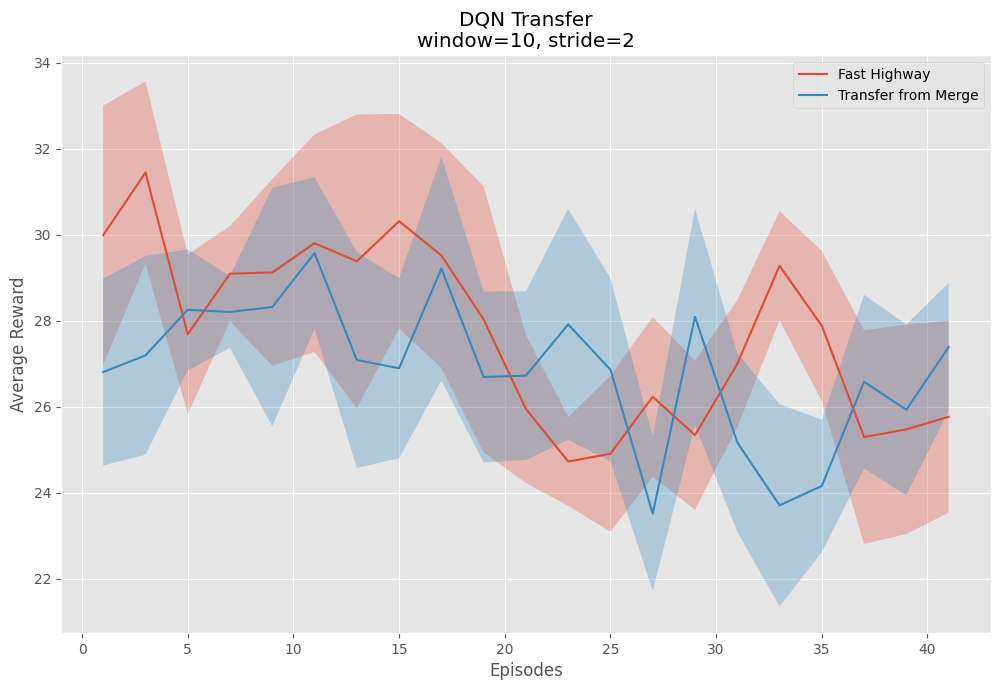

Attempting to display video: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_eval_ep0-episode-0.mp4
Video not found: C:\Users\Harsh raj\web\web-project\changed_web\unified_project\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\Videos\highway-fast-v0_eval_ep0-episode-0.mp4. Available videos: ['C:\\Users\\Harsh raj\\web\\web-project\\changed_web\\unified_project\\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\\Videos\\merge-v0_eval_ep0-episode-0.mp4', 'C:\\Users\\Harsh raj\\web\\web-project\\changed_web\\unified_project\\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\\Videos\\merge-v0_eval_ep1-episode-0.mp4', 'C:\\Users\\Harsh raj\\web\\web-project\\changed_web\\unified_project\\Deep-Reinforcement-Learning-based-Decision-Making-in-Autonomous-Driving-Tasks\\Videos\\merge-v0_eval_ep2-

In [19]:
# Train and evaluate DQN with transfer learning from merge-v0 to highway-fast-v0
video_path = os.path.join(path_HW5, 'Videos')
model_path_source = os.path.join(path_HW5, 'Models/1_Models_merge')
model_path_dest = os.path.join(path_HW5, 'Models/3_Models_merge_transfer_learning_to_fastHighway')
data_path_3 = os.path.join(path_HW5, 'Data_Average_Reward/3_Data_merge_transfer_learning_to_fastHighway')
env_name_source = 'merge-v0'
env_name = 'highway-fast-v0'
env = gym.make(env_name, render_mode='rgb_array')
env.unwrapped.config.update({
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 5,
        "features": ["presence", "x", "y", "vx", "vy"],
        "absolute": False
    },
    "policy_frequency": 5,
    "screen_width": 600,
    "screen_height": 150,
    "centering_position": [0.5, 0.5],
    "scaling": 1.0
})

# Check if source models exist
print("Checking for source models for Cell 12...")
for iter in range(1, 6):
    local_path = os.path.join(model_path_source, f'Models_Run_{iter}', f'checkpoint_dqn_state_{env_name_source}_local_200.pth')
    target_path = os.path.join(model_path_source, f'Models_Run_{iter}', f'checkpoint_dqn_state_{env_name_source}_target_200.pth')
    if not os.path.exists(local_path) or not os.path.exists(target_path):
        print(f"Error: Source model {local_path} or {target_path} not found. Run Cell 10 first.")
        raise FileNotFoundError(f"Missing {local_path} or {target_path}")

dqn_transfer = DQN(env, env_name, model_path_dest, data_path_3, 'linear', env_name_source, model_path_source, transfer_episode=200)

# Training
print("Starting training for Cell 12...")
df_reward_transfer = dqn_transfer.train_with_state(n_iteration=[1,2,3,4,5], n_training_episodes=50, max_step=10000)

# Evaluation
print("Starting evaluation for Cell 12...")
avg_reward, crash_rate = dqn_transfer.evaluation(os.path.join(video_path, "fastHighway_transferred_from_merge.mp4"), 'state', iter_num=5, evaluate_episode_num=200)

# Plot Comparison
print("Generating comparison plot for Cell 12...")
df_fast = pd.read_excel(os.path.join(data_path_2, 'Episodes_reward_run_5.xlsx'))
df_trans = pd.read_excel(os.path.join(data_path_3, 'Episodes_reward_run_5.xlsx'))
ep_fast = df_fast.T.to_numpy()
ep_trans = df_trans.T.to_numpy()
fig, ax = plt.subplots(figsize=(12, 7.5))
ax = show_and_plot().plot_training_result(ep_fast, ax, 'DQN Fast', 'Fast Highway', window=10, stride=2)
ax = show_and_plot().plot_training_result(ep_trans, ax, 'DQN Transfer', 'Transfer from Merge', window=10, stride=2)
plt.legend()
plt.show()
fig.savefig(os.path.join(path_HW5, 'Images/2-fastHighway_with_and_without_transfer_learning_training_on-state.png'), dpi=300)
show_and_plot().show_video(video_path, "highway-fast-v0_eval_ep0-episode-0.mp4")

# Cell 13: Part 4 - Merge-v0 with CNN and Observation

In [20]:
# Train and evaluate DQN on merge-v0 using CNN and observation input
video_path = os.path.join(path_HW5, 'Videos')
model_path = os.path.join(path_HW5, 'Models/4_Models_CNN_merge')
data_path_4 = os.path.join(path_HW5, 'Data_Average_Reward/4_Data_CNN_merge')
env_name = 'merge-v0'
env = gym.make(env_name, render_mode='rgb_array')
env.unwrapped.config.update({
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 5,
        "features": ["presence", "x", "y", "vx", "vy"],
        "absolute": False
    },
    "policy_frequency": 10,
    "screen_width": 600,
    "screen_height": 150,
    "centering_position": [0.5, 0.5],
    "scaling": 1.0
})
dqn_merge_cnn = DQN(env, env_name, model_path, data_path_4, 'cnn')

# Training
print("Starting training for Cell 13...")
df_reward_merge_c거나 = dqn_merge_cnn.train_with_observation(n_iteration=[1,2,3,4,5], n_training_episodes=50, max_step=10000)

# Evaluation
print("Starting evaluation for Cell 13...")
avg_reward, crash_rate = dqn_merge_cnn.evaluation(os.path.join(video_path, "merge_observation_CNN.mp4"), 'observation', iter_num=5, evaluate_episode_num=200)

# Plotting
print("Generating plot for Cell 13...")
df_merge = pd.read_excel(os.path.join(data_path_1, 'Episodes_reward_run_5.xlsx'))
df_merge_cnn = pd.read_excel(os.path.join(data_path_4, 'Episodes_reward_run_5.xlsx'))
ep_merge = df_merge.T.to_numpy()
ep_merge_cnn = df_merge_cnn.T.to_numpy()
fig, ax = plt.subplots(figsize=(12, 7.5))
ax = show_and_plot().plot_training_result(ep_merge, ax, 'DQN Merge', 'Merge task with state', window=10, stride=2)
ax = show_and_plot().plot_training_result(ep_merge_cnn, ax, 'DQN Merge CNN', 'Merge task with CNN and observation', window=10, stride=2)
plt.legend()
plt.show()
fig.savefig(os.path.join(path_HW5, 'Images/3-merge_cnn_observation_merge_linear_state.png'), dpi=300)
show_and_plot().show_video(video_path, "merge-v0_eval_ep0-episode-0.mp4")

# Statistical Significance
t_test = ttest_ind(np.mean(ep_merge, axis=0), np.mean(ep_merge_cnn, axis=0))
print(f"P-value between Merge (state) and Merge (CNN, observation): {t_test.pvalue:.4f}")

Starting training for Cell 13...
Training agent with observation for merge-v0...


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 1	Avg Reward: 107.20	Epsilon: 0.995crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 2	Avg Reward: 96.17	Epsilon: 0.990crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

crashTrue
overFalse
Episode 3	Avg Reward: 92.06	Epsilon: 0.985crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ove

Episode 4	Avg Reward: 108.42	Epsilon: 0.980crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashTrue
overFalse
Episode 5	Avg Reward: 104.92	Epsilon: 0.975crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashTrue
overFalse
Episode 6	Avg Reward: 107.26	Epsilon: 0.970crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashTrue
overFalse
Episode 7	Avg Reward: 111.24	Epsilon: 0.966crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 8	Avg Reward: 114.44	Epsilon: 0.961crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 9	Avg Reward: 115.89	Epsilon: 0.956crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
ov

crashTrue
overFalse
Episode 10	Avg Reward: 119.00	Epsilon: 0.951
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse


crashTrue
overFalse
Episode 11	Avg Reward: 114.66	Epsilon: 0.946crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 12	Avg Reward: 110.84	Epsilon: 0.942crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overFalse
crashFalse
overFalse
crashTrue
overFalse
Episode 13	Avg Reward: 107.69	Epsilon: 0.937crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashFalse
overTrue
Episode 14	Avg Reward: 112.11	Epsilon: 0.932crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

crashTrue
overFalse
Episode 15	Avg Reward: 108.59	Epsilon: 0.928crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
o

Episode 16	Avg Reward: 105.75	Epsilon: 0.923crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse


Episode 17	Avg Reward: 105.63	Epsilon: 0.918crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse


Episode 18	Avg Reward: 104.35	Epsilon: 0.914crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse
overFalse
crashFalse


Iterations:   0%|          | 0/5 [09:38<?, ?it/s]

crashFalse
overFalse


AttributeError: 'NoneType' object has no attribute 'get_image'

# Cell 14: Statistical Significance Check for Highway-Fast-v0

In [ ]:
# Compare highway-fast-v0 with and without transfer learning
df_fast = pd.read_excel(os.path.join(data_path_2, 'Episodes_reward_run_5.xlsx'))
df_trans = pd.read_excel(os.path.join(data_path_3, 'Episodes_reward_run_5.xlsx'))
ep_fast = df_fast.T.to_numpy()
ep_trans = df_trans.T.to_numpy()
t_test = ttest_ind(np.mean(ep_fast, axis=0), np.mean(ep_trans, axis=0))
print(f"P-value between fastHighway and transferred: {t_test.pvalue:.4f}")

# Cell 15: Multi-Agent Extension Setup

In [ ]:
# Define CACC environment wrapper
from gymnasium import Wrapper

class CACCWrapper(Wrapper):
    def __init__(self, env, target_gap=5.0):
        super().__init__(env)
        self.target_gap = target_gap
        self.num_agents = env.unwrapped.config.get('controlled_vehicles', 1)

    def step(self, action):
        obs, rewards, terminateds, truncateds, infos = self.env.step(action)
        new_rewards = {}
        for agent_id in obs:
            state = obs[agent_id]
            own_pos = state[0, 1]  # x-position
            own_vel = state[0, 3]  # vx
            gap_penalty = 0
            collision_penalty = 0
            accel_penalty = 0
            for i in range(1, state.shape[0]):
                if state[i, 0] == 1:  # Vehicle present
                    rel_x = state[i, 1] - own_pos
                    if 0 < rel_x < 10:  # Ahead
                        gap_error = abs(rel_x - self.target_gap)
                        gap_penalty += -gap_error
                        if rel_x < 2:
                            collision_penalty = -10
            accel_penalty = -0.1 * (action[agent_id] - 2)**2  # Action 2 = idle
            new_rewards[agent_id] = rewards[agent_id] + gap_penalty + collision_penalty + accel_penalty
        return obs, new_rewards, terminateds, truncateds, infos

# Cell 16: Multi-Agent DQN for CACC

In [ ]:
# Define multi-agent DQN for CACC
class MultiAgentDQN:
    def __init__(self, env, env_name, model_path, data_path, network_type, num_agents=4, pretrained_path=None):
        self.env = CACCWrapper(env.unwrapped)
        self.env_name = env_name
        self.model_path = model_path
        self.data_path = data_path
        self.network_type = network_type
        self.num_agents = num_agents
        self.agents = [Agent(int(np.prod(self.env.observation_space[0].shape)), self.env.action_space[0].n, network_type, seed=11+i) for i in range(num_agents)]
        self.df_reward = pd.DataFrame()
        self.seed = [0, 5, 11, 123, 487]
        if pretrained_path:
            for agent in self.agents:
                agent.qnetwork_local.load_state_dict(torch.load(pretrained_path, map_location=device))
                agent.qnetwork_target.load_state_dict(torch.load(pretrained_path.replace('local', 'target'), map_location=device))

    def train(self, n_iteration, n_training_episodes=50, max_step=10000, eps_start=1.0, eps_end=0.001, eps_decay=0.995):
        print("Training multi-agent CACC...")
        for iter in tqdm(n_iteration, desc="Iterations"):
            episodes_reward = [[] for _ in range(self.num_agents)]
            os.makedirs(os.path.join(self.model_path, f'Models_Run_{iter}'), exist_ok=True)
            eps = eps_start

            for episode_num in tqdm(range(1, n_training_episodes + 1), desc=f"Iter {iter} Episodes", leave=False):
                obs_dict, _ = self.env.reset()
                done_dict = {i: False for i in range(self.num_agents)}
                total_rewards = [0] * self.num_agents
                for _ in range(max_step):
                    actions_dict = {i: self.agents[i].act(obs_dict[i].ravel(), eps) for i in range(self.num_agents)}
                    next_obs, rewards, terminateds, truncateds, _ = self.env.step(actions_dict)
                    for i in range(self.num_agents):
                        if not done_dict[i]:
                            self.agents[i].step(obs_dict[i].ravel(), actions_dict[i], rewards[i], next_obs[i].ravel(), terminateds[i] or truncateds[i])
                            total_rewards[i] += rewards[i]
                            done_dict[i] = terminateds[i] or truncateds[i]
                    obs_dict = next_obs
                    if all(done_dict.values()):
                        break
                for i in range(self.num_agents):
                    episodes_reward[i].append(total_rewards[i])
                eps = max(eps_end, eps_decay * eps)
                print(f'\rEpisode {episode_num}\tAvg Reward: {[np.mean(episodes_reward[i]):.2f for i in range(self.num_agents)]}\tEpsilon: {eps:.3f}', end='')
                if episode_num % 10 == 0:
                    print(f'\rEpisode {episode_num}\tAvg Reward: {[np.mean(episodes_reward[i]):.2f for i in range(self.num_agents)]}\tEpsilon: {eps:.3f}')
                if episode_num % 200 == 0:
                    for i, agent in enumerate(self.agents):
                        torch.save(agent.qnetwork_local.state_dict(), os.path.join(self.model_path, f'Models_Run_{iter}', f'agent_{i}_local_{episode_num}.pth'))
                        torch.save(agent.qnetwork_target.state_dict(), os.path.join(self.model_path, f'Models_Run_{iter}', f'agent_{i}_target_{episode_num}.pth'))

            for i in range(self.num_agents):
                self.df_reward[f'Run_{iter}_Agent_{i}'] = episodes_reward[i]
            self.df_reward.to_excel(os.path.join(self.data_path, f'Episodes_reward_run_{iter}.xlsx'), index=False)
        return self.df_reward

    def evaluate(self, video_file, iter_num, evaluate_episode_num, num_episodes=5):
        video_dir = os.path.dirname(video_file)
        os.makedirs(video_dir, exist_ok=True)
        os.environ["SDL_VIDEODRIVER"] = "windows"
        total_rewards = [0] * self.num_agents
        crashes = [0] * self.num_agents
        for ep in range(num_episodes):
            env_wrapped = RecordVideo(self.env, video_folder=video_dir, name_prefix=f"cacc_eval_ep{ep}")
            obs_dict, _ = env_wrapped.reset()
            done_dict = {i: False for i in range(self.num_agents)}
            ep_rewards = [0] * self.num_agents
            while not all(done_dict.values()):
                actions_dict = {i: self.agents[i].act(obs_dict[i].ravel(), eps=0) for i in range(self.num_agents)}
                next_obs, rewards, terminateds, truncateds, infos = env_wrapped.step(actions_dict)
                for i in range(self.num_agents):
                    if not done_dict[i]:
                        ep_rewards[i] += rewards[i]
                        if 'crashed' in infos[i] and infos[i]['crashed']:
                            crashes[i] += 1
                        done_dict[i] = terminateds[i] or truncateds[i]
                obs_dict = next_obs
            env_wrapped.close()
            for i in range(self.num_agents):
                total_rewards[i] += ep_rewards[i]
                print(f"Episode {ep+1} Agent {i} Reward: {ep_rewards[i]:.2f}")
        avg_rewards = [total_rewards[i] / num_episodes for i in range(self.num_agents)]
        crash_rates = [crashes[i] / num_episodes for i in range(self.num_agents)]
        print(f"Average Rewards: {avg_rewards}")
        print(f"Crash Rates: {crash_rates}")
        pd.DataFrame({
            'Episode': list(range(1, num_episodes+1)),
            **{f'Agent_{i}_Reward': [ep_rewards[i] for ep in range(num_episodes)] for i in range(self.num_agents)}
        }).to_csv(os.path.join(video_dir, f"{self.env_name}_cacc_eval_rewards.csv"), index=False)
        return avg_rewards, crash_rates

# Cell 17: Run MARL-CACC

In [ ]:
# Train and evaluate multi-agent DQN for CACC
video_path = os.path.join(path_HW5, 'Videos')
model_path_cacc = os.path.join(path_HW5, 'Models/5_Models_CACC')
data_path_cacc = os.path.join(path_HW5, 'Data_Average_Reward/5_Data_CACC')
env_name = 'highway-v0'
env = gym.make(env_name, render_mode='rgb_array')
env.unwrapped.config.update({
    'controlled_vehicles': 4,
    'observation': {
        'type': 'Kinematics',
        'vehicles_count': 5,
        'features': ['presence', 'x', 'y', 'vx', 'vy']
    },
    'policy_frequency': 5
})

# Initialize with transfer learning from highway-fast-v0
dqn_cacc = MultiAgentDQN(
    env, env_name, model_path_cacc, data_path_cacc, 'linear', num_agents=4,
    pretrained_path=os.path.join(path_HW5, 'Models/2_Models_fastHighway/Models_Run_5/checkpoint_dqn_state_highway-fast-v0_local_200.pth')
)

# Training
print("Starting training for Cell 17...")
df_reward_cacc = dqn_cacc.train(n_iteration=[1,2,3,4,5], n_training_episodes=50)

# Evaluation
print("Starting evaluation for Cell 17...")
avg_rewards, crash_rates = dqn_cacc.evaluate(os.path.join(video_path, "cacc.mp4"), iter_num=5, evaluate_episode_num=200)

# Plotting
print("Generating plot for Cell 17...")
df_cacc = pd.read_excel(os.path.join(data_path_cacc, 'Episodes_reward_run_5.xlsx'))
ep_cacc = df_cacc.T.to_numpy()
fig, ax = plt.subplots(figsize=(12, 7.5))
for i in range(4):
    ax = show_and_plot().plot_training_result(ep_cacc[i::4], ax, 'MARL-CACC', f'Agent {i}', window=10, stride=2)
plt.legend()
plt.show()
fig.savefig(os.path.join(path_HW5, 'Images/5-CACC-Rewards.png'), dpi=300)
show_and_plot().show_video(video_path, "cacc_eval_ep0-episode-0.mp4")

# Cell 18: Statistical Significance Check for CACC

In [ ]:
# Compare CACC with transferred highway-fast-v0
df_trans = pd.read_excel(os.path.join(data_path_3, 'Episodes_reward_run_5.xlsx'))
df_cacc = pd.read_excel(os.path.join(data_path_cacc, 'Episodes_reward_run_5.xlsx'))
ep_trans = df_trans.T.to_numpy()
ep_cacc = df_cacc.T.to_numpy()
t_test = ttest_ind(np.mean(ep_trans, axis=0), np.mean(ep_cacc[0::4], axis=0))
print(f"P-value between transferred fastHighway and CACC Agent 0: {t_test.pvalue:.4f}")